# TimeSTAMP Data Density

This notebook views the heatmaps from a numbers-perspective by calculating skewness, kurtosis, and kernel density estimate (KDE), as well as graphing the flows' probability distribution functions (PDFs). Though the heatmaps, including the one in the final manuscript, are largely qualitative, these statistics were calculated to support our conclusions from another perspective.

**Stats calculated:**
* Skewness
* Kurtosis
* Kernel Density Estimate

**Authors:**
* Andrew Roman, andrew.roman@commonspirit.org, aeroman2@asu.edu
* Jakob Perivolotis, jperivol@asu.edu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.rcParams['figure.dpi'] = 300 # Set image resolution

In [2]:
csf_flow_df = pd.read_csv('../../data/CSF_Flow_TimeSTAMP_measurements.csv')
csf_flow_df.head()

,patient_id,age,spinal_region,image_group,image_number,foramen_magnum_distance,super_ante_displacement,infer_ante_displacement,super_post_displacement,infer_post_displacement,super_ante_width,infer_ante_width,super_post_width,infer_post_width,ante_qual_direction,post_qual_direction,image_quality
0,2,24,C2-3,1,1,NaN,-3.29,-5.02,2.26,-1.067,3.29,4.339,3.65,2.503,caudal,rostral,high
1,2,24,C2-3,1,2,NaN,3.676,1.808,1.804,0,5.348,4.391,3.04,2.45,rostral,rostral,high
2,2,24,C2-3,1,3,NaN,-4.33,-9.174,0.8,-4.159,4.099,4.015,2.879,2.042,caudal,caudal,high
3,2,24,C2-3,1,4,NaN,1.194,0,1.717,0,4.207,4.192,3.1,3.385,rostral,rostral,high
4,2,24,C2-3,1,5,NaN,2.585,2.58,1.173,0,4.541,4.4,3.058,2.364,rostral,rostral,high


### Set ID, quality-related, and other columns to Pandas' Categorical type

In [3]:
csf_flow_df['patient_id'] = pd.Categorical(csf_flow_df['patient_id'])
csf_flow_df['image_number'] = pd.Categorical(csf_flow_df['image_number'])
csf_flow_df['ante_qual_direction'] = pd.Categorical(csf_flow_df['ante_qual_direction'])
csf_flow_df['post_qual_direction'] = pd.Categorical(csf_flow_df['post_qual_direction'])

quality_order = ['unreadable', 'low', 'medium', 'high']
csf_flow_df['image_quality'] = pd.Categorical(csf_flow_df['image_quality'],
                                                categories=quality_order,
                                                ordered=True
                                               )

spinal_region_order = ['C2-3', 'C5-6', 'C7-T1', 'T1', 'T1-2', 'T3-4', 'T6-7']
csf_flow_df['spinal_region'] = pd.Categorical(csf_flow_df['spinal_region'],
                                                categories=spinal_region_order,
                                                ordered=True
                                               )

### Set measurement columns to floats

In [4]:
numeric_columns = ['super_ante_displacement', 'infer_ante_displacement', 'super_post_displacement', 'infer_post_displacement',
                   'super_ante_width', 'infer_ante_width', 'super_post_width', 'infer_post_width']
csf_flow_df[numeric_columns] = csf_flow_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
csf_flow_df.dtypes

patient_id                 category
age                           int64
spinal_region              category
image_group                   int64
image_number               category
foramen_magnum_distance     float64
super_ante_displacement     float64
infer_ante_displacement     float64
super_post_displacement     float64
infer_post_displacement     float64
super_ante_width            float64
infer_ante_width            float64
super_post_width            float64
infer_post_width            float64
ante_qual_direction        category
post_qual_direction        category
image_quality              category
dtype: object

# Common Functions and Variables

In [5]:
def get_csf_flow_by_patient_id_and_region(df, patient_id, spinal_region):
    # Get data from one of the CSF flow dataframes for one patient in one vertebral region (`C2-3`, etc.)
    data = df[(df['patient_id'] == patient_id) & (df['spinal_region'] == spinal_region)]
    return data

def get_csf_flow_by_region(df, region):
    # Get all flows for all patients from one region
    data = df[df['spinal_region'] == region]
    return data

# Create midline shift measurements

Since it is possible for fluid to be measured as moving rostrally, caudally, or bidirectionally, one way to quantify displacement is to calculate where the middle of the displaced fluid is at image capture (i.e. when t=2.5s).

The midline is calculated as the middle of the final boundaries of the CSF when the image is capture, or essentially the average of the measurements. For example, the midline of anterior displacement is `(superior anterior displacement + inferior anterior displacement) / 2`.

In [6]:
csf_flow_df['anterior_midline_shift'] = (csf_flow_df['super_ante_displacement'] + csf_flow_df['infer_ante_displacement']) / 2
csf_flow_df['posterior_midline_shift'] = (csf_flow_df['super_post_displacement'] + csf_flow_df['infer_post_displacement']) / 2
csf_flow_df.head()

,patient_id,age,spinal_region,image_group,image_number,foramen_magnum_distance,super_ante_displacement,infer_ante_displacement,super_post_displacement,infer_post_displacement,super_ante_width,infer_ante_width,super_post_width,infer_post_width,ante_qual_direction,post_qual_direction,image_quality,anterior_midline_shift,posterior_midline_shift
0,2,24,C2-3,1,1,NaN,-3.290,-5.020,2.260,-1.067,3.290,4.339,3.650,2.503,caudal,rostral,high,-4.1550,0.5965
1,2,24,C2-3,1,2,NaN,3.676,1.808,1.804,0.000,5.348,4.391,3.040,2.450,rostral,rostral,high,2.7420,0.9020
2,2,24,C2-3,1,3,NaN,-4.330,-9.174,0.800,-4.159,4.099,4.015,2.879,2.042,caudal,caudal,high,-6.7520,-1.6795
3,2,24,C2-3,1,4,NaN,1.194,0.000,1.717,0.000,4.207,4.192,3.100,3.385,rostral,rostral,high,0.5970,0.8585
4,2,24,C2-3,1,5,NaN,2.585,2.580,1.173,0.000,4.541,4.400,3.058,2.364,rostral,rostral,high,2.5825,0.5865


## Create a separate dataframe with only high- or medium-quality images

This dataframe will be used to repeat analyses to see if data quality affects reliability.

In [7]:
csf_flow_high_med = csf_flow_df[csf_flow_df['image_quality'].isin(['medium', 'high'])]
csf_flow_high_med = csf_flow_high_med.reset_index(drop=True)
csf_flow_high_med.head()

,patient_id,age,spinal_region,image_group,image_number,foramen_magnum_distance,super_ante_displacement,infer_ante_displacement,super_post_displacement,infer_post_displacement,super_ante_width,infer_ante_width,super_post_width,infer_post_width,ante_qual_direction,post_qual_direction,image_quality,anterior_midline_shift,posterior_midline_shift
0,2,24,C2-3,1,1,NaN,-3.290,-5.020,2.260,-1.067,3.290,4.339,3.650,2.503,caudal,rostral,high,-4.1550,0.5965
1,2,24,C2-3,1,2,NaN,3.676,1.808,1.804,0.000,5.348,4.391,3.040,2.450,rostral,rostral,high,2.7420,0.9020
2,2,24,C2-3,1,3,NaN,-4.330,-9.174,0.800,-4.159,4.099,4.015,2.879,2.042,caudal,caudal,high,-6.7520,-1.6795
3,2,24,C2-3,1,4,NaN,1.194,0.000,1.717,0.000,4.207,4.192,3.100,3.385,rostral,rostral,high,0.5970,0.8585
4,2,24,C2-3,1,5,NaN,2.585,2.580,1.173,0.000,4.541,4.400,3.058,2.364,rostral,rostral,high,2.5825,0.5865


## Visualize midlines of displacement (All Quality Images)

Text(0.5, 1.0, 'Anterior Midline Shift for All Images, All Subjects')

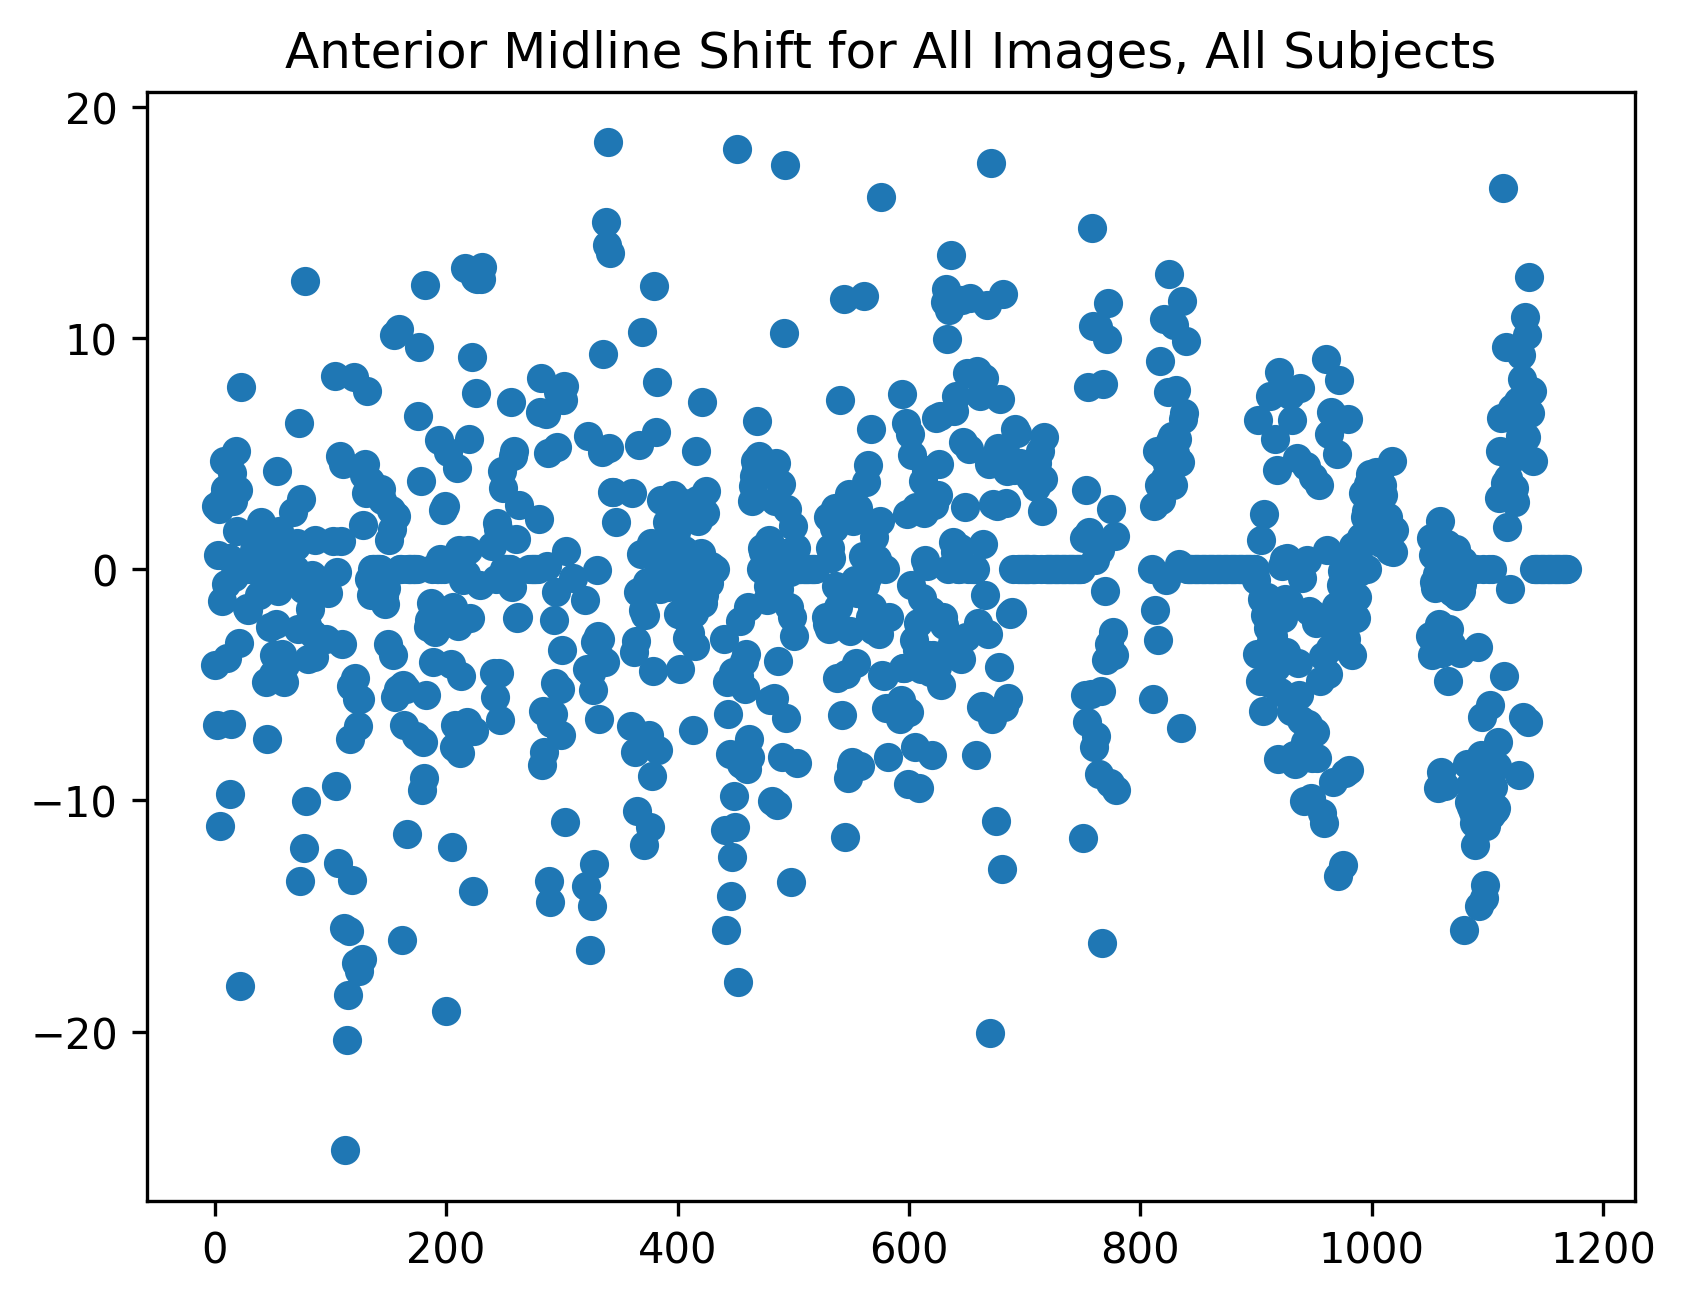

In [8]:
x = range(len(csf_flow_df['anterior_midline_shift']))
plt.scatter(x, csf_flow_df['anterior_midline_shift'])
plt.title('Anterior Midline Shift for All Images, All Subjects')

Text(0.5, 1.0, 'Posterior Midline Shift for All Images, All Subjects')

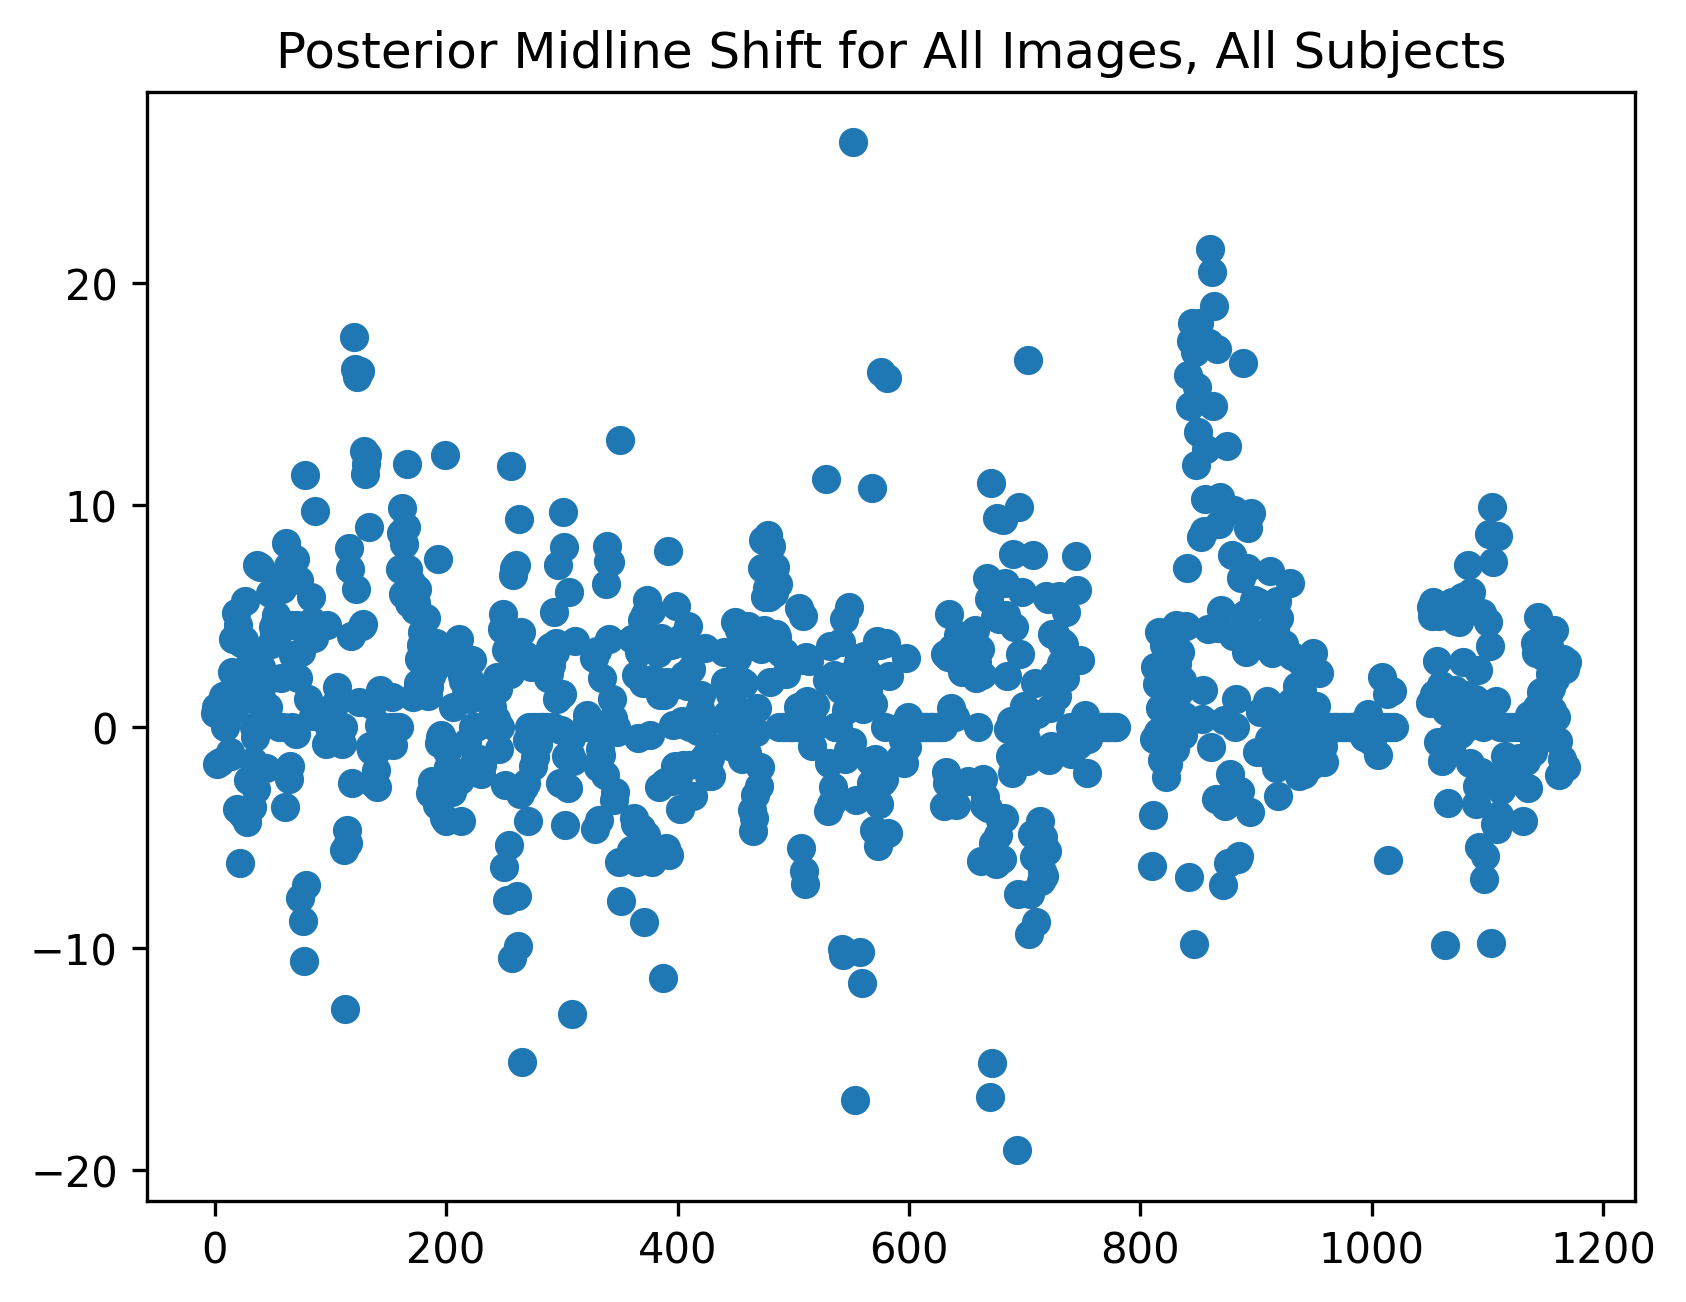

In [9]:
x = range(len(csf_flow_df['posterior_midline_shift']))
plt.scatter(x, csf_flow_df['posterior_midline_shift'])
plt.title('Posterior Midline Shift for All Images, All Subjects')

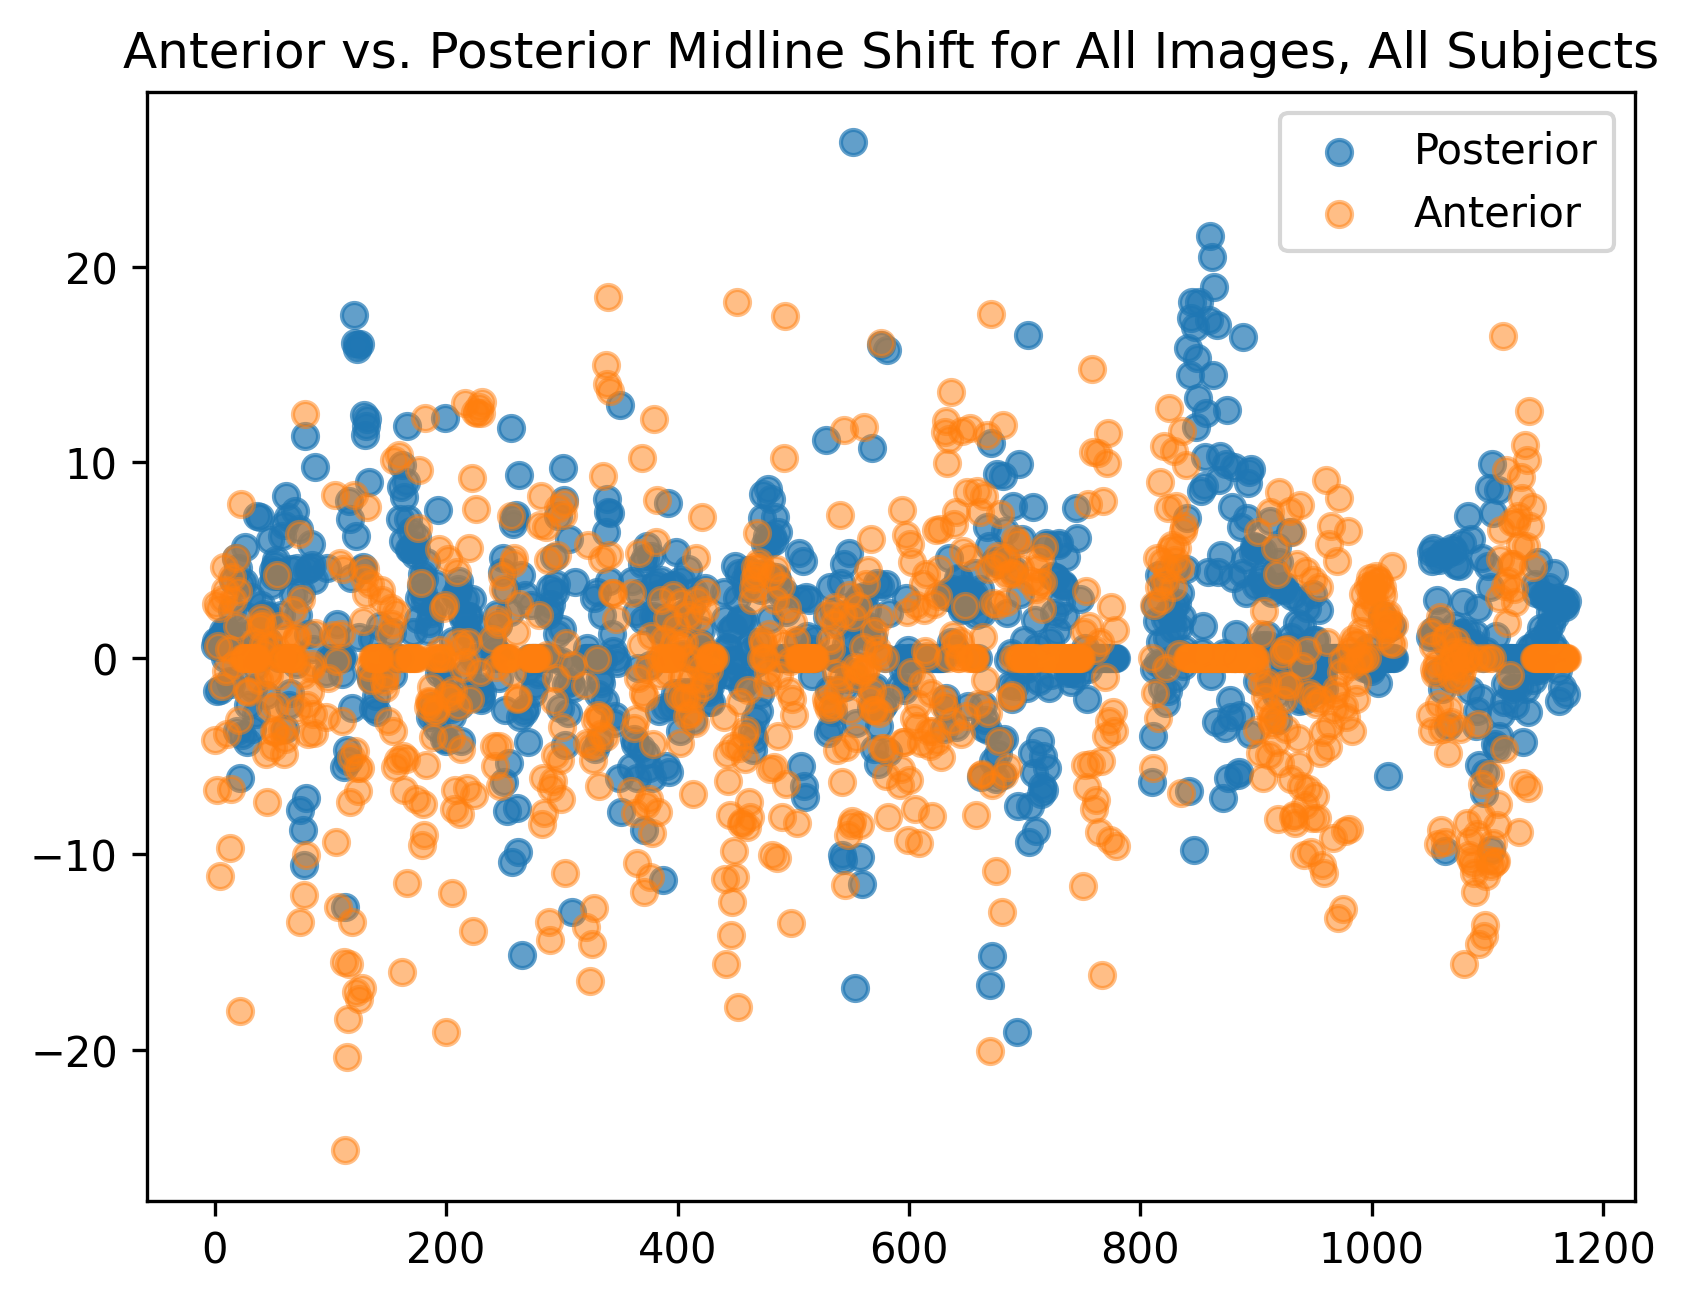

In [10]:
x = range(len(csf_flow_df['posterior_midline_shift']))
plt.scatter(x, csf_flow_df['posterior_midline_shift'], label='Posterior', alpha=0.7)
plt.scatter(x, csf_flow_df['anterior_midline_shift'], label='Anterior', alpha=0.5)
plt.title('Anterior vs. Posterior Midline Shift for All Images, All Subjects')
plt.legend()

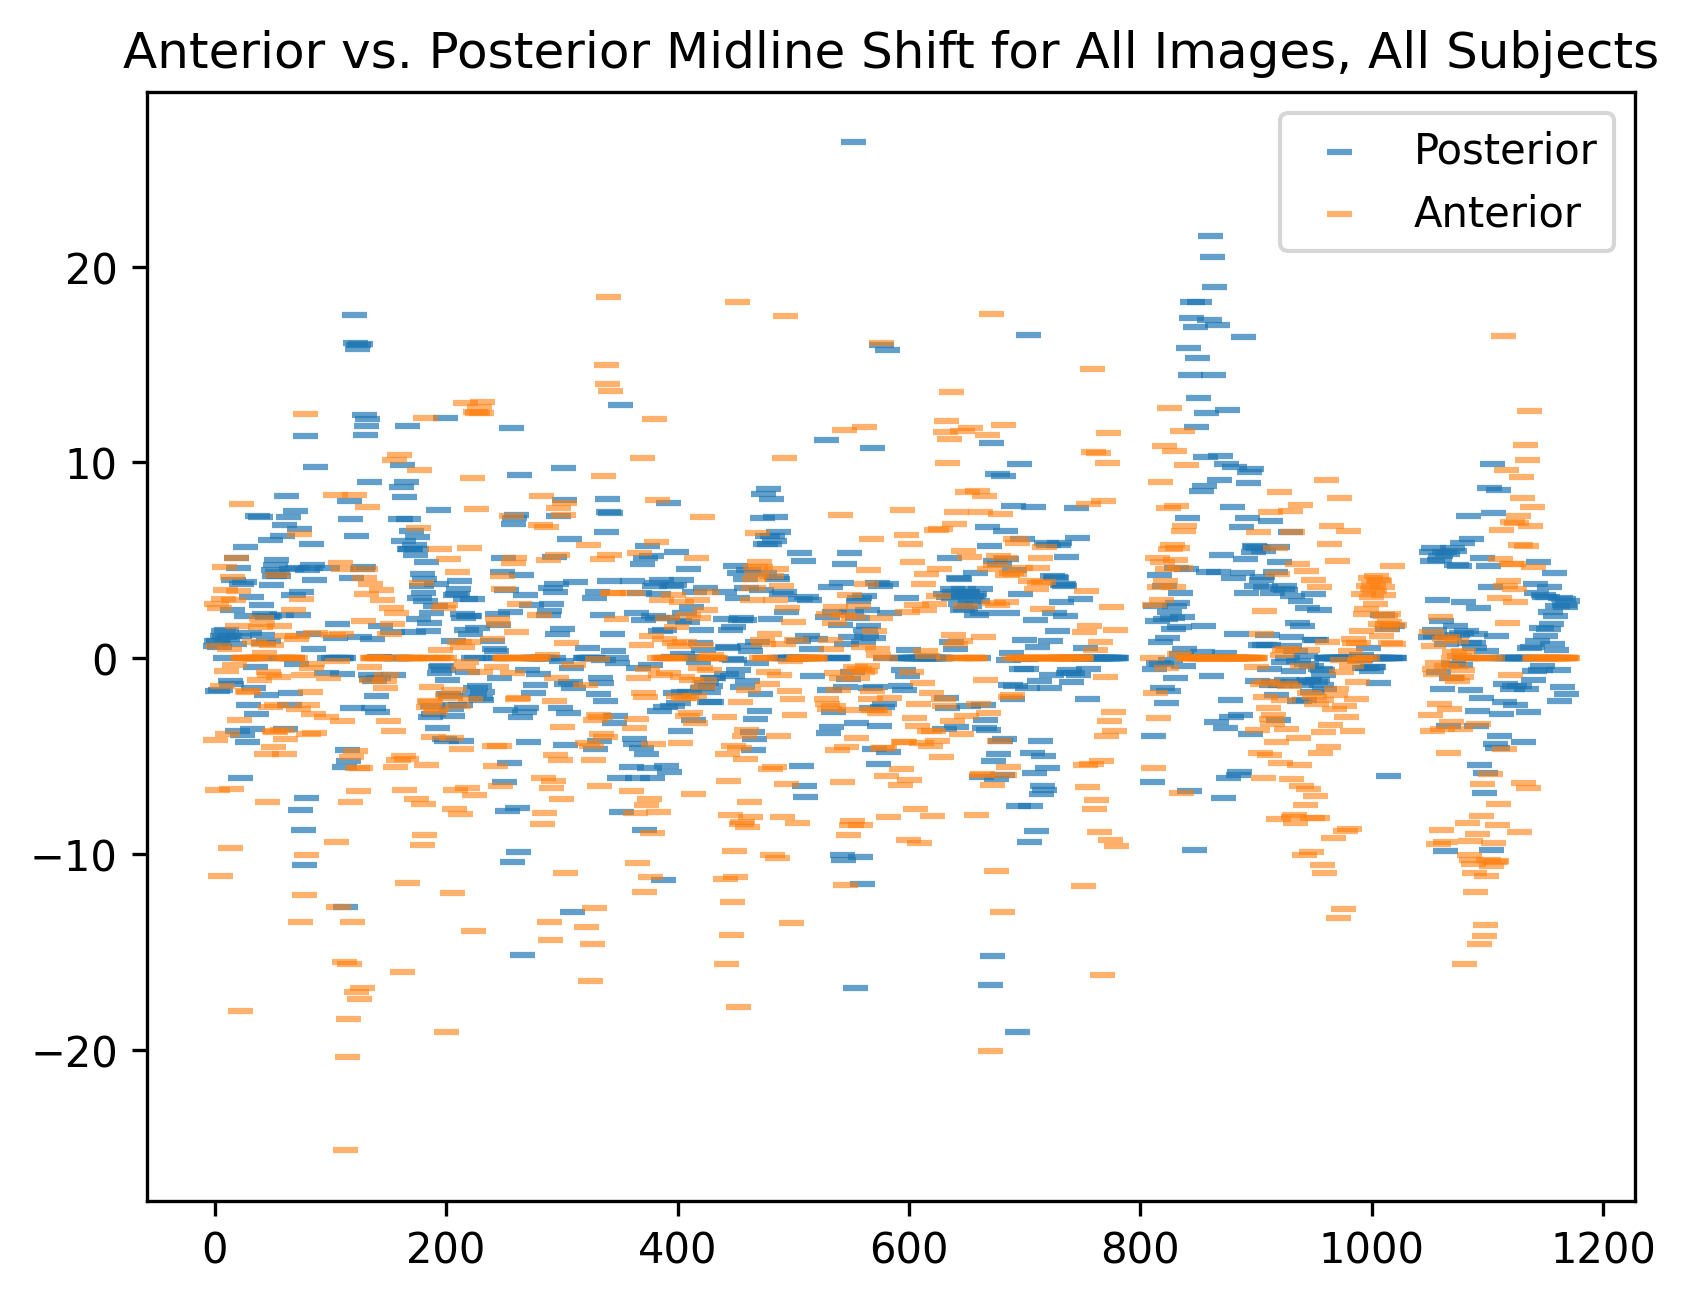

In [11]:
x = range(len(csf_flow_df['posterior_midline_shift']))
plt.scatter(x, csf_flow_df['posterior_midline_shift'], label='Posterior', alpha=0.7, marker='_')
plt.scatter(x, csf_flow_df['anterior_midline_shift'], label='Anterior', alpha=0.6, marker='_')
plt.title('Anterior vs. Posterior Midline Shift for All Images, All Subjects')
plt.legend()

# Skew, Kurtosis, and Kernel Density Estimate (KDE)

Show the skew and kurtosis of the flow data at all regions by using the middle of the displaced CSF fluid (i.e. the `*_midline_shift` columns)

In [12]:
def calculate_kernel_density(data):
    # Get the plottable kernel density estimate (KDE) for a 1D array of data
    kde = stats.gaussian_kde(data)
    return kde

In [13]:
# Get all flows by region
c2_3 = get_csf_flow_by_region(csf_flow_df, 'C2-3').copy()
c5_6 = get_csf_flow_by_region(csf_flow_df, 'C5-6').copy()
t1_2 = get_csf_flow_by_region(csf_flow_df, 'T1-2').copy()
t3_4 = get_csf_flow_by_region(csf_flow_df, 'T3-4').copy()
t6_7 = get_csf_flow_by_region(csf_flow_df, 'T6-7').copy()

In [14]:
# Drop all missing values (NaNs)
c2_3_without_na = c2_3[(c2_3['anterior_midline_shift'].notna()) & (c2_3['posterior_midline_shift'].notna())]
c5_6_without_na = c5_6[(c5_6['anterior_midline_shift'].notna()) & (c5_6['posterior_midline_shift'].notna())]
t1_2_without_na = t1_2[(t1_2['anterior_midline_shift'].notna()) & (t1_2['posterior_midline_shift'].notna())]
t3_4_without_na = t3_4[(t3_4['anterior_midline_shift'].notna()) & (t3_4['posterior_midline_shift'].notna())]
t6_7_without_na = t6_7[(t6_7['anterior_midline_shift'].notna()) & (t6_7['posterior_midline_shift'].notna())]

In [15]:
# Get the anterior and posterior data for all regions
c2_3_anterior_midlines = c2_3_without_na['anterior_midline_shift']
c2_3_posterior_midlines = c2_3_without_na['posterior_midline_shift']

c5_6_anterior_midlines = c5_6_without_na['anterior_midline_shift']
c5_6_posterior_midlines = c5_6_without_na['posterior_midline_shift']

t1_2_anterior_midlines = t1_2_without_na['anterior_midline_shift']
t1_2_posterior_midlines = t1_2_without_na['posterior_midline_shift']

t3_4_anterior_midlines = t3_4_without_na['anterior_midline_shift']
t3_4_posterior_midlines = t3_4_without_na['posterior_midline_shift']

t6_7_anterior_midlines = t6_7_without_na['anterior_midline_shift']
t6_7_posterior_midlines = t6_7_without_na['posterior_midline_shift']

### Calculate Skewness and Kurtosis

In [16]:
# C2-3 Anterior
c2_3_skewness = stats.skew(c2_3_anterior_midlines)
c2_3_kurtosis = stats.kurtosis(c2_3_anterior_midlines)
c2_3_skewness, c2_3_kurtosis

(-0.10316016869838725, 0.3503615581569006)

In [17]:
# C2-3 Posterior
c2_3_skewness = stats.skew(c2_3_posterior_midlines)
c2_3_kurtosis = stats.kurtosis(c2_3_posterior_midlines)
c2_3_skewness, c2_3_kurtosis

(0.23849466266288374, 1.9444801798539197)

In [18]:
# C5-6 Anterior
c5_6_skewness = stats.skew(c5_6_anterior_midlines)
c5_6_kurtosis = stats.kurtosis(c5_6_anterior_midlines)
c5_6_skewness, c5_6_kurtosis

(-0.01607165382266774, 0.802156187778793)

In [19]:
# C5-6 Posterior
c5_6_skewness = stats.skew(c5_6_posterior_midlines)
c5_6_kurtosis = stats.kurtosis(c5_6_posterior_midlines)
c5_6_skewness, c5_6_kurtosis

(-0.41962626084754984, 0.6384712651000126)

In [20]:
# T1-2 Anterior
t1_2_skewness = stats.skew(t1_2_anterior_midlines)
t1_2_kurtosis = stats.kurtosis(t1_2_anterior_midlines)
t1_2_skewness, t1_2_kurtosis

(-0.25313635253632827, -0.09748926174959882)

In [21]:
# T1-2 Posterior
t1_2_skewness = stats.skew(t1_2_posterior_midlines)
t1_2_kurtosis = stats.kurtosis(t1_2_posterior_midlines)
t1_2_skewness, t1_2_kurtosis

(0.39797426778821887, 2.6883230570187475)

In [22]:
# T3-4 Anterior
t3_4_skewness = stats.skew(t3_4_anterior_midlines)
t3_4_kurtosis = stats.kurtosis(t3_4_anterior_midlines)
t3_4_skewness, t3_4_kurtosis

(1.1450474562073845, 4.238628929234534)

In [23]:
# T3-4 Posterior
t3_4_skewness = stats.skew(t3_4_posterior_midlines)
t3_4_kurtosis = stats.kurtosis(t3_4_posterior_midlines)
t3_4_skewness, t3_4_kurtosis

(0.8383566277890863, 1.5404720167416066)

In [24]:
# T6-7 Anterior
t6_7_skewness = stats.skew(t6_7_anterior_midlines)
t6_7_kurtosis = stats.kurtosis(t6_7_anterior_midlines)
t6_7_skewness, t6_7_kurtosis
# This one will print a warning due to missing/NaN values

(3.09617068390078, 20.11563010201657)

In [25]:
# T6-7 Posterior
t6_7_skewness = stats.skew(t6_7_posterior_midlines)
t6_7_kurtosis = stats.kurtosis(t6_7_posterior_midlines)
t6_7_skewness, t6_7_kurtosis

(0.5071614974156545, 0.10114112883112503)

# Calculate and Visualize Kernel Density Estimates for All Regions

### Calculate KDE and PDF for C2-3 (Anterior and Posterior)

In [26]:
c2_3_anterior_kde = calculate_kernel_density(c2_3_anterior_midlines)
c2_3_anterior_x = np.linspace(c2_3_anterior_midlines.min(), c2_3_anterior_midlines.max())

c2_3_anterior_pdf = c2_3_anterior_kde.evaluate(c2_3_anterior_x)

In [27]:
c2_3_posterior_kde = calculate_kernel_density(c2_3_posterior_midlines)
c2_3_posterior_x = np.linspace(c2_3_posterior_midlines.min(), c2_3_posterior_midlines.max())

c2_3_posterior_pdf = c2_3_posterior_kde.evaluate(c2_3_posterior_x)

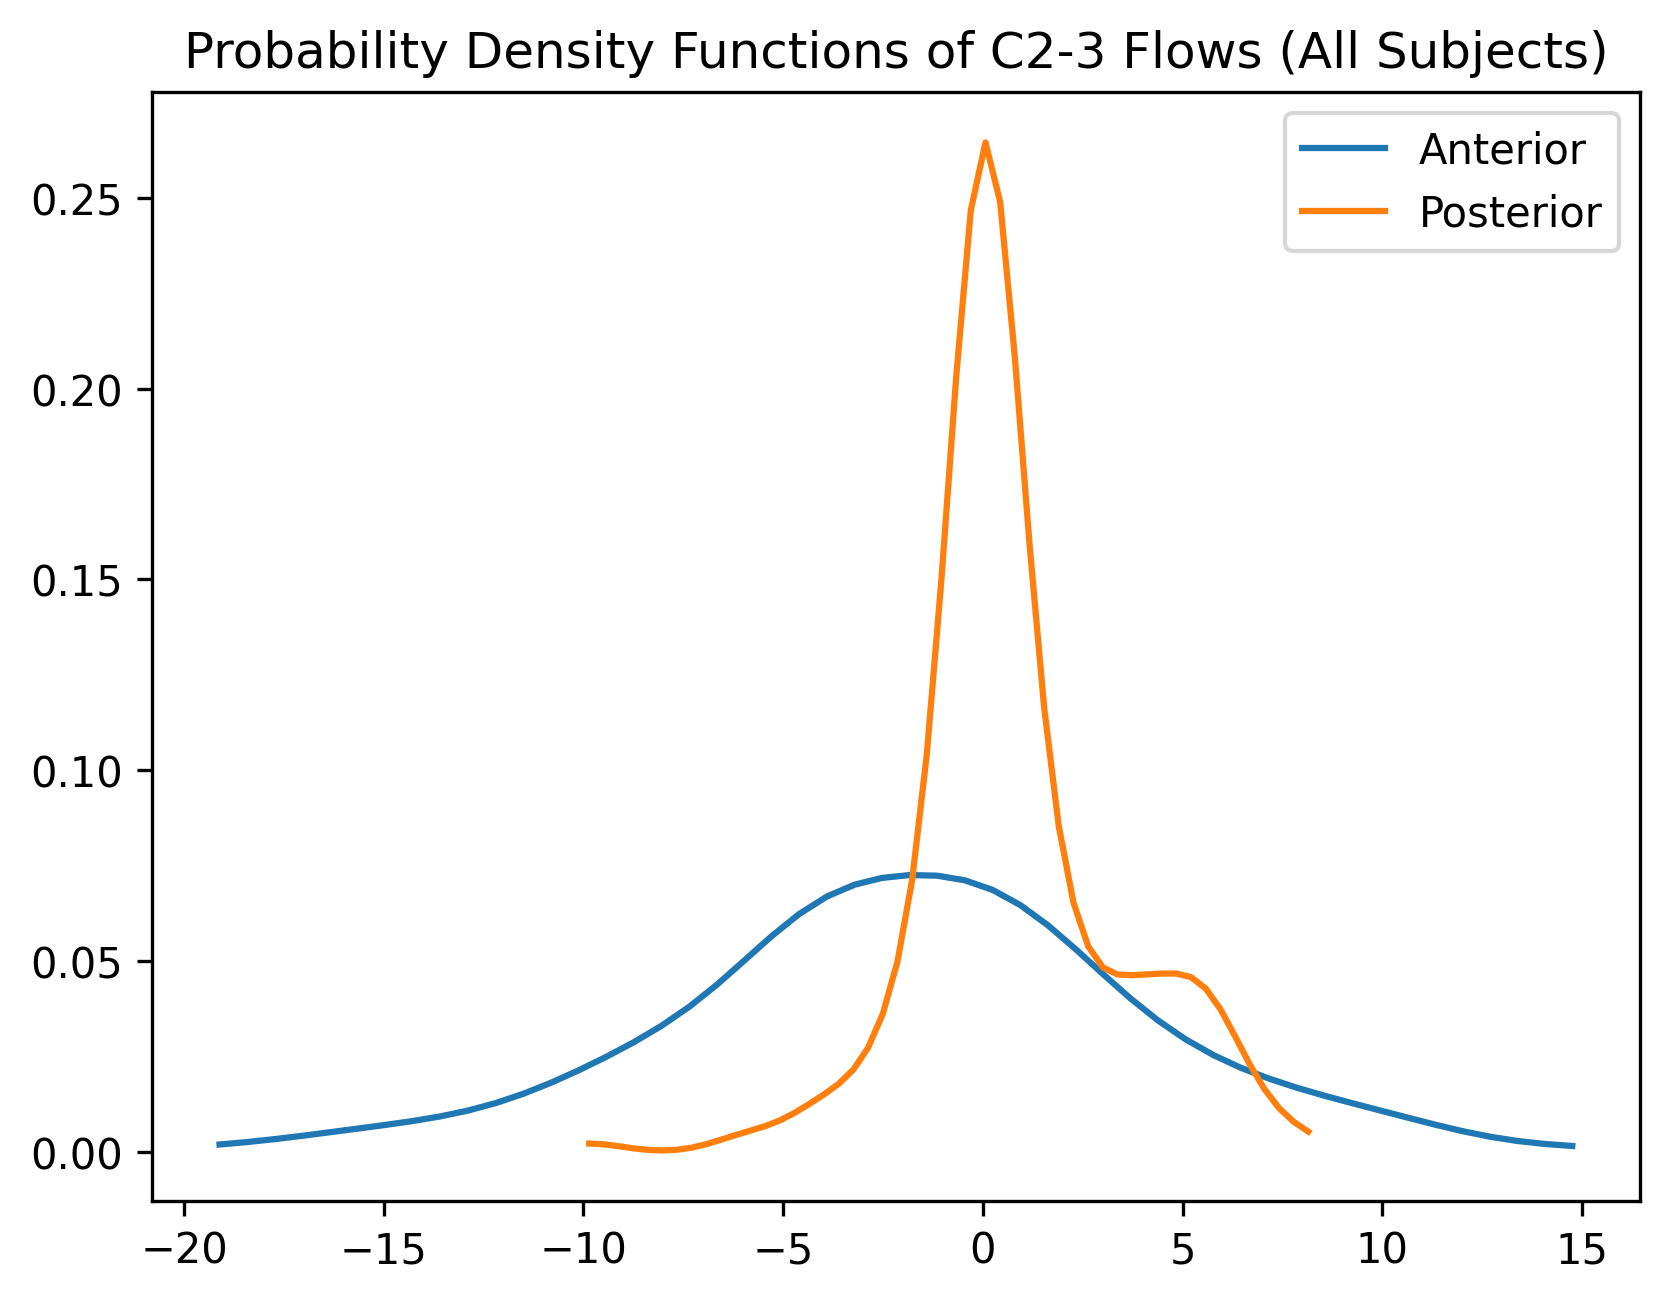

In [28]:
plt.plot(c2_3_anterior_x, c2_3_anterior_pdf, label='Anterior')
plt.plot(c2_3_posterior_x, c2_3_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of C2-3 Flows (All Subjects)')
plt.legend()

Text(0.5, 1.0, 'Kernel Density Estimate of Midlines of CSF Flow at C2-3 (Anterior)')

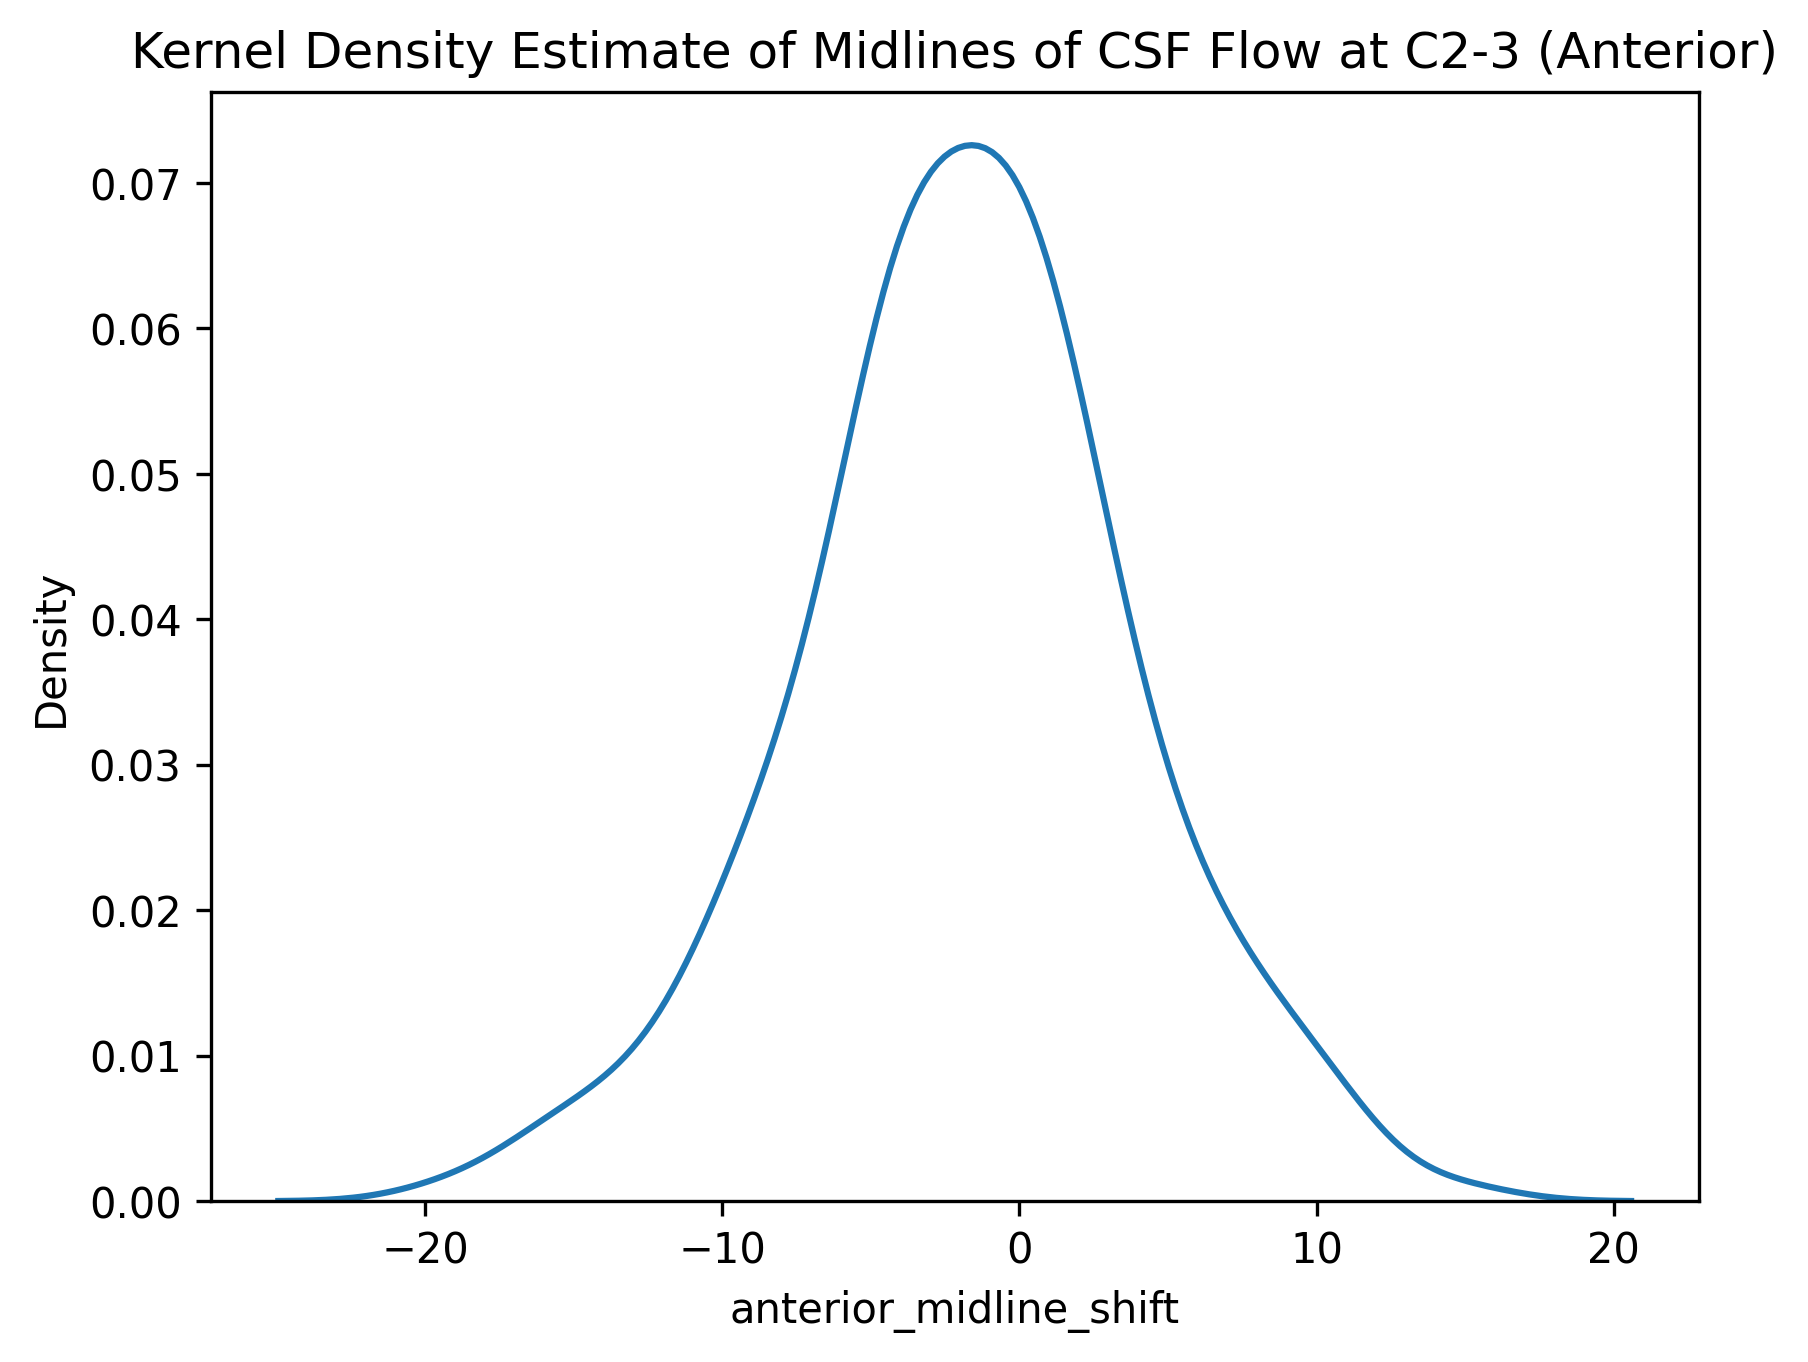

In [29]:
plot = sns.kdeplot(c2_3_anterior_midlines)
plot.set_title('Kernel Density Estimate of Midlines of CSF Flow at C2-3 (Anterior)')

### Calculate KDE and PDF for C5-6 (Anterior and Posterior)

In [30]:
c5_6_anterior_kde = calculate_kernel_density(c5_6_anterior_midlines)
c5_6_anterior_x = np.linspace(c5_6_anterior_midlines.min(), c5_6_anterior_midlines.max())
c5_6_anterior_pdf = c5_6_anterior_kde.evaluate(c5_6_anterior_x)

c5_6_posterior_kde = calculate_kernel_density(c5_6_posterior_midlines)
c5_6_posterior_x = np.linspace(c5_6_posterior_midlines.min(), c5_6_posterior_midlines.max())
c5_6_posterior_pdf = c5_6_posterior_kde.evaluate(c5_6_posterior_x)

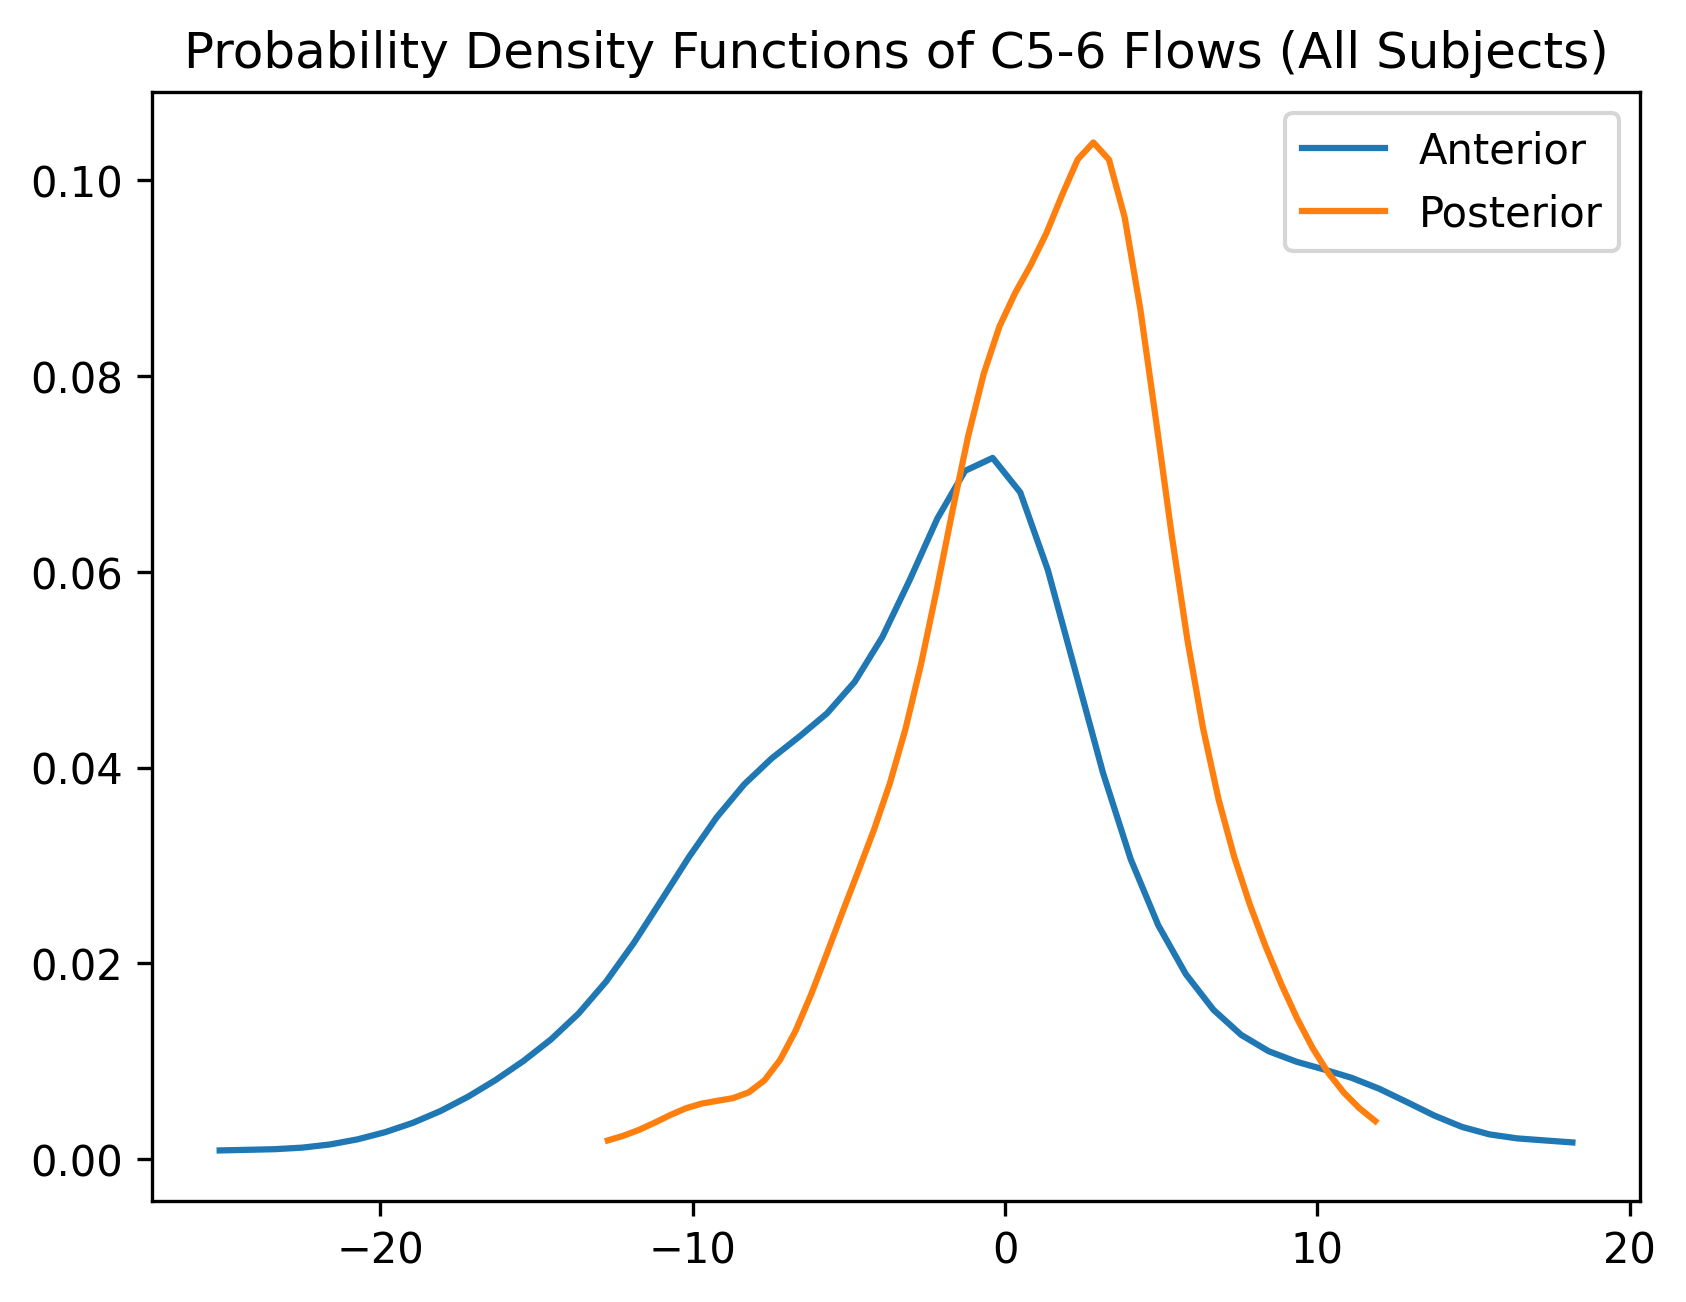

In [31]:
plt.plot(c5_6_anterior_x, c5_6_anterior_pdf, label='Anterior')
plt.plot(c5_6_posterior_x, c5_6_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of C5-6 Flows (All Subjects)')
plt.legend()

### Calculate KDE and PDF for T1-2 (Anterior and Posterior)

In [32]:
t1_2_anterior_kde = calculate_kernel_density(t1_2_anterior_midlines)
t1_2_anterior_x = np.linspace(t1_2_anterior_midlines.min(), t1_2_anterior_midlines.max())
t1_2_anterior_pdf = t1_2_anterior_kde.evaluate(t1_2_anterior_x)

t1_2_posterior_kde = calculate_kernel_density(t1_2_posterior_midlines)
t1_2_posterior_x = np.linspace(t1_2_posterior_midlines.min(), t1_2_posterior_midlines.max())
t1_2_posterior_pdf = t1_2_posterior_kde.evaluate(t1_2_posterior_x)

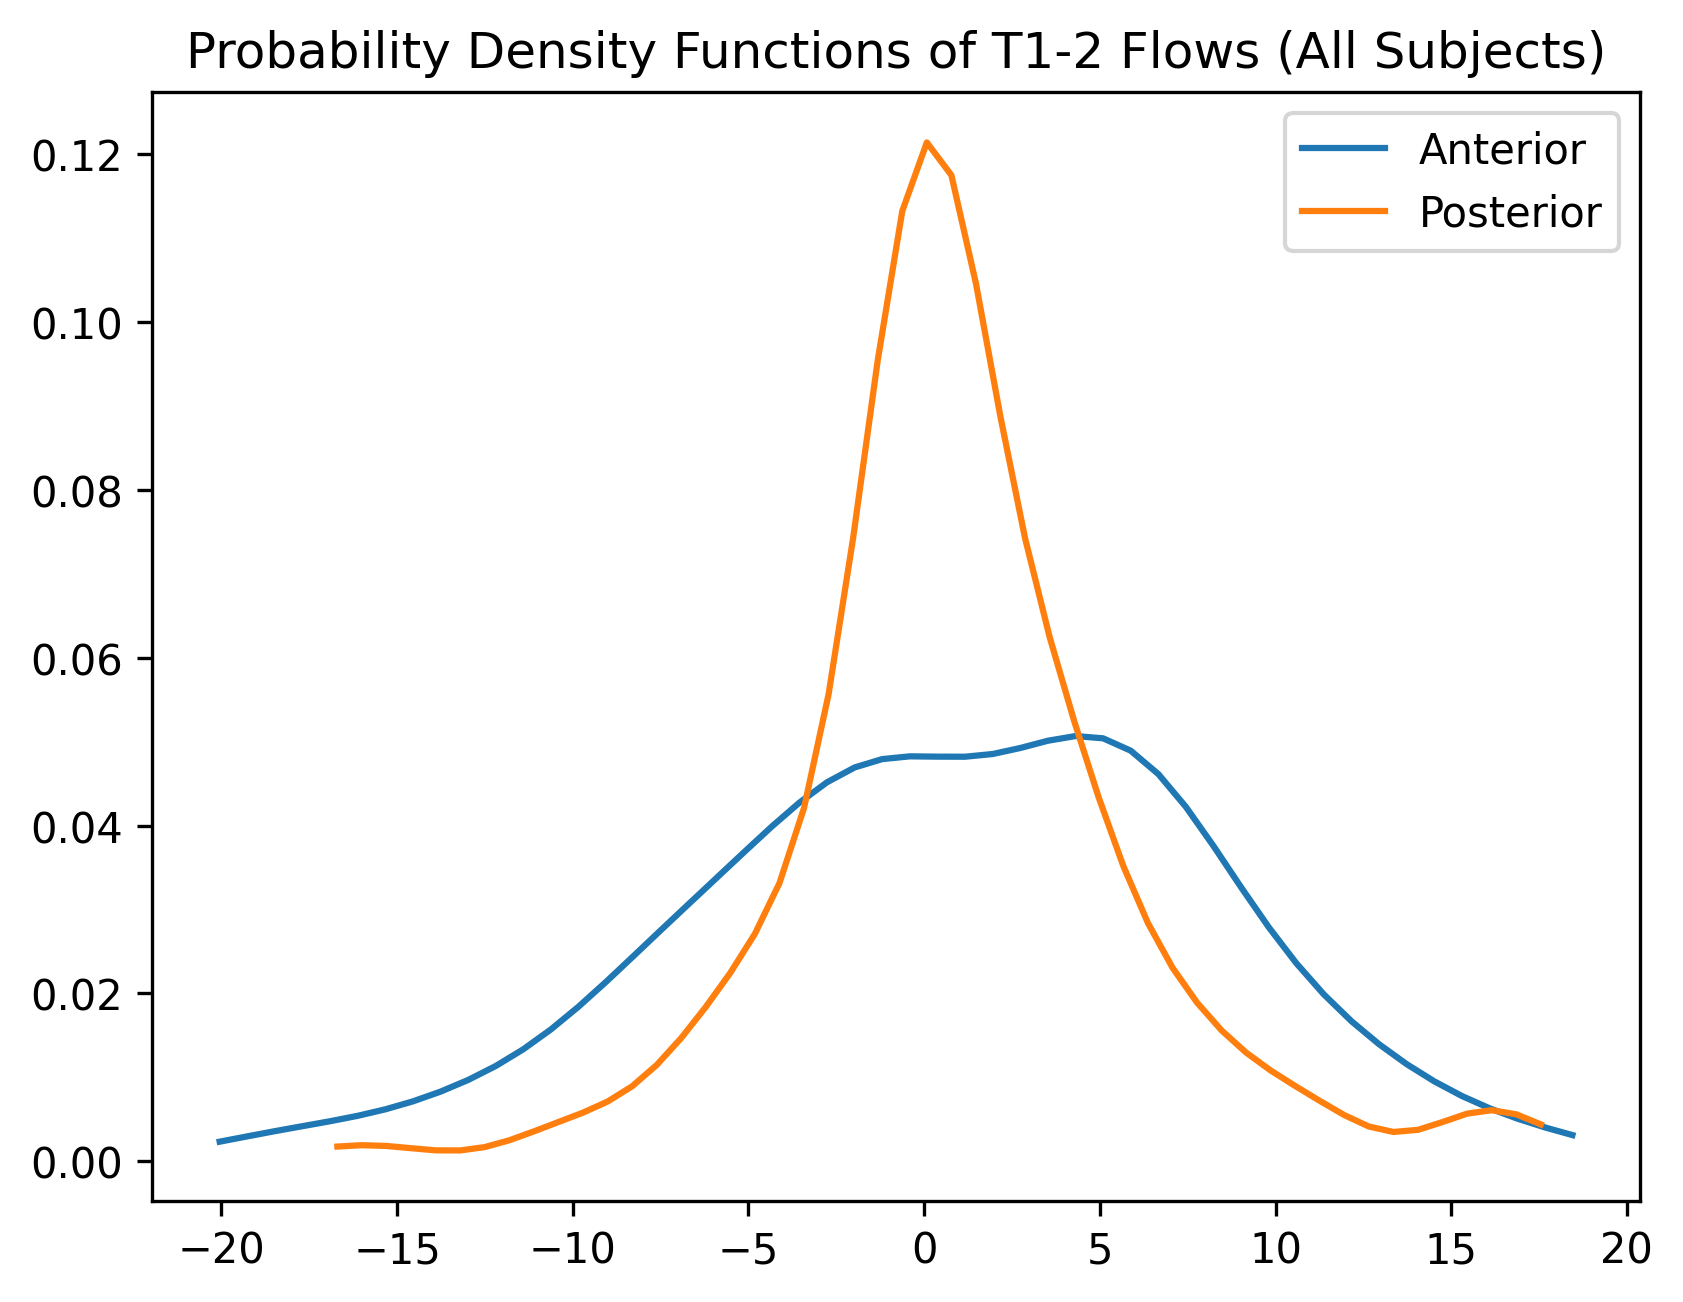

In [33]:
plt.plot(t1_2_anterior_x, t1_2_anterior_pdf, label='Anterior')
plt.plot(t1_2_posterior_x, t1_2_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of T1-2 Flows (All Subjects)')
plt.legend()

### Calculate KDE and PDF for T3-4 (Anterior and Posterior)

In [34]:
t3_4_anterior_kde = calculate_kernel_density(t3_4_anterior_midlines)
t3_4_anterior_x = np.linspace(t3_4_anterior_midlines.min(), t3_4_anterior_midlines.max())
t3_4_anterior_pdf = t3_4_anterior_kde.evaluate(t3_4_anterior_x)

t3_4_posterior_kde = calculate_kernel_density(t3_4_posterior_midlines)
t3_4_posterior_x = np.linspace(t3_4_posterior_midlines.min(), t3_4_posterior_midlines.max())
t3_4_posterior_pdf = t3_4_posterior_kde.evaluate(t3_4_posterior_x)

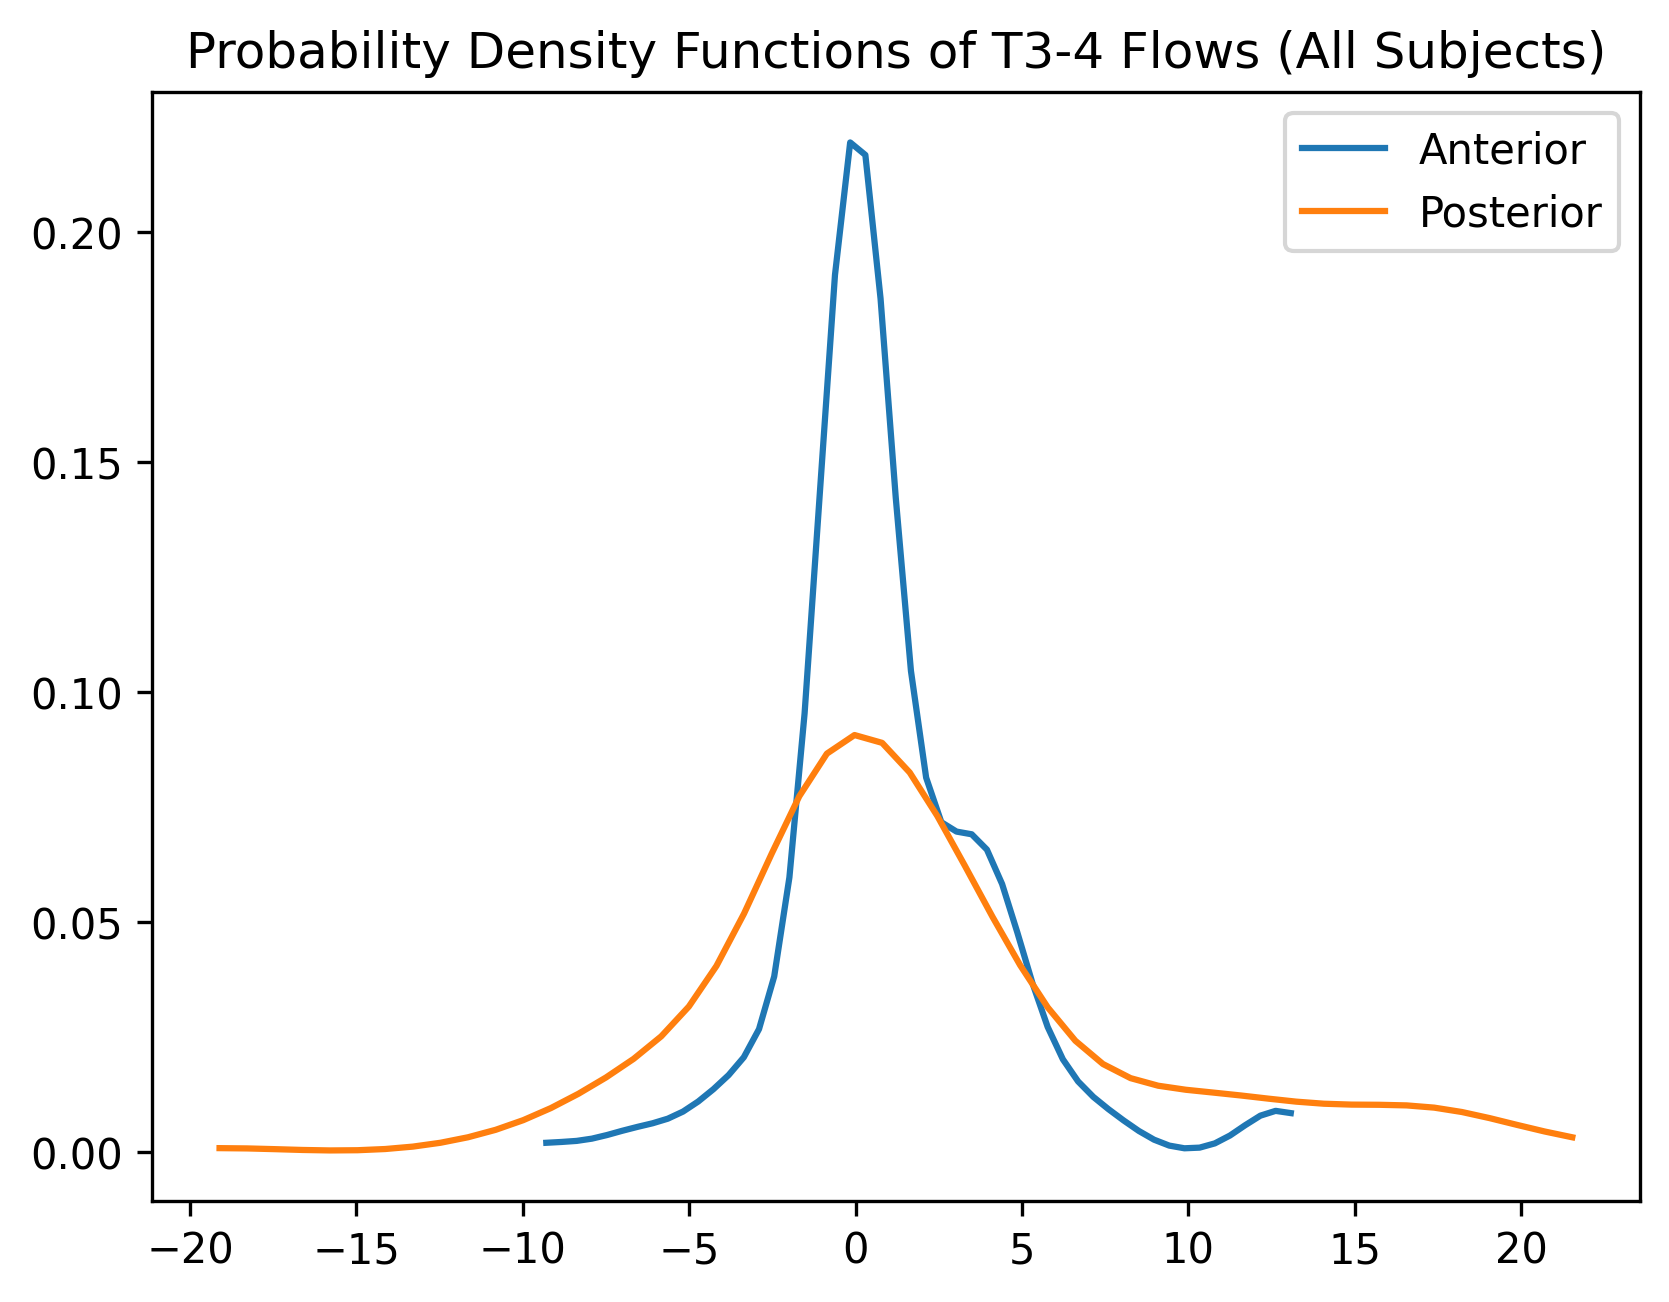

In [35]:
plt.plot(t3_4_anterior_x, t3_4_anterior_pdf, label='Anterior')
plt.plot(t3_4_posterior_x, t3_4_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of T3-4 Flows (All Subjects)')
plt.legend()

### Calculate KDE and PDF for T6-7 (Anterior and Posterior)

In [36]:
t6_7_anterior_kde = calculate_kernel_density(t6_7_anterior_midlines)
t6_7_anterior_x = np.linspace(t6_7_anterior_midlines.min(), t6_7_anterior_midlines.max())
t6_7_anterior_pdf = t6_7_anterior_kde.evaluate(t6_7_anterior_x)

t6_7_posterior_kde = calculate_kernel_density(t6_7_posterior_midlines)
t6_7_posterior_x = np.linspace(t6_7_posterior_midlines.min(), t6_7_posterior_midlines.max())
t6_7_posterior_pdf = t6_7_posterior_kde.evaluate(t6_7_posterior_x)

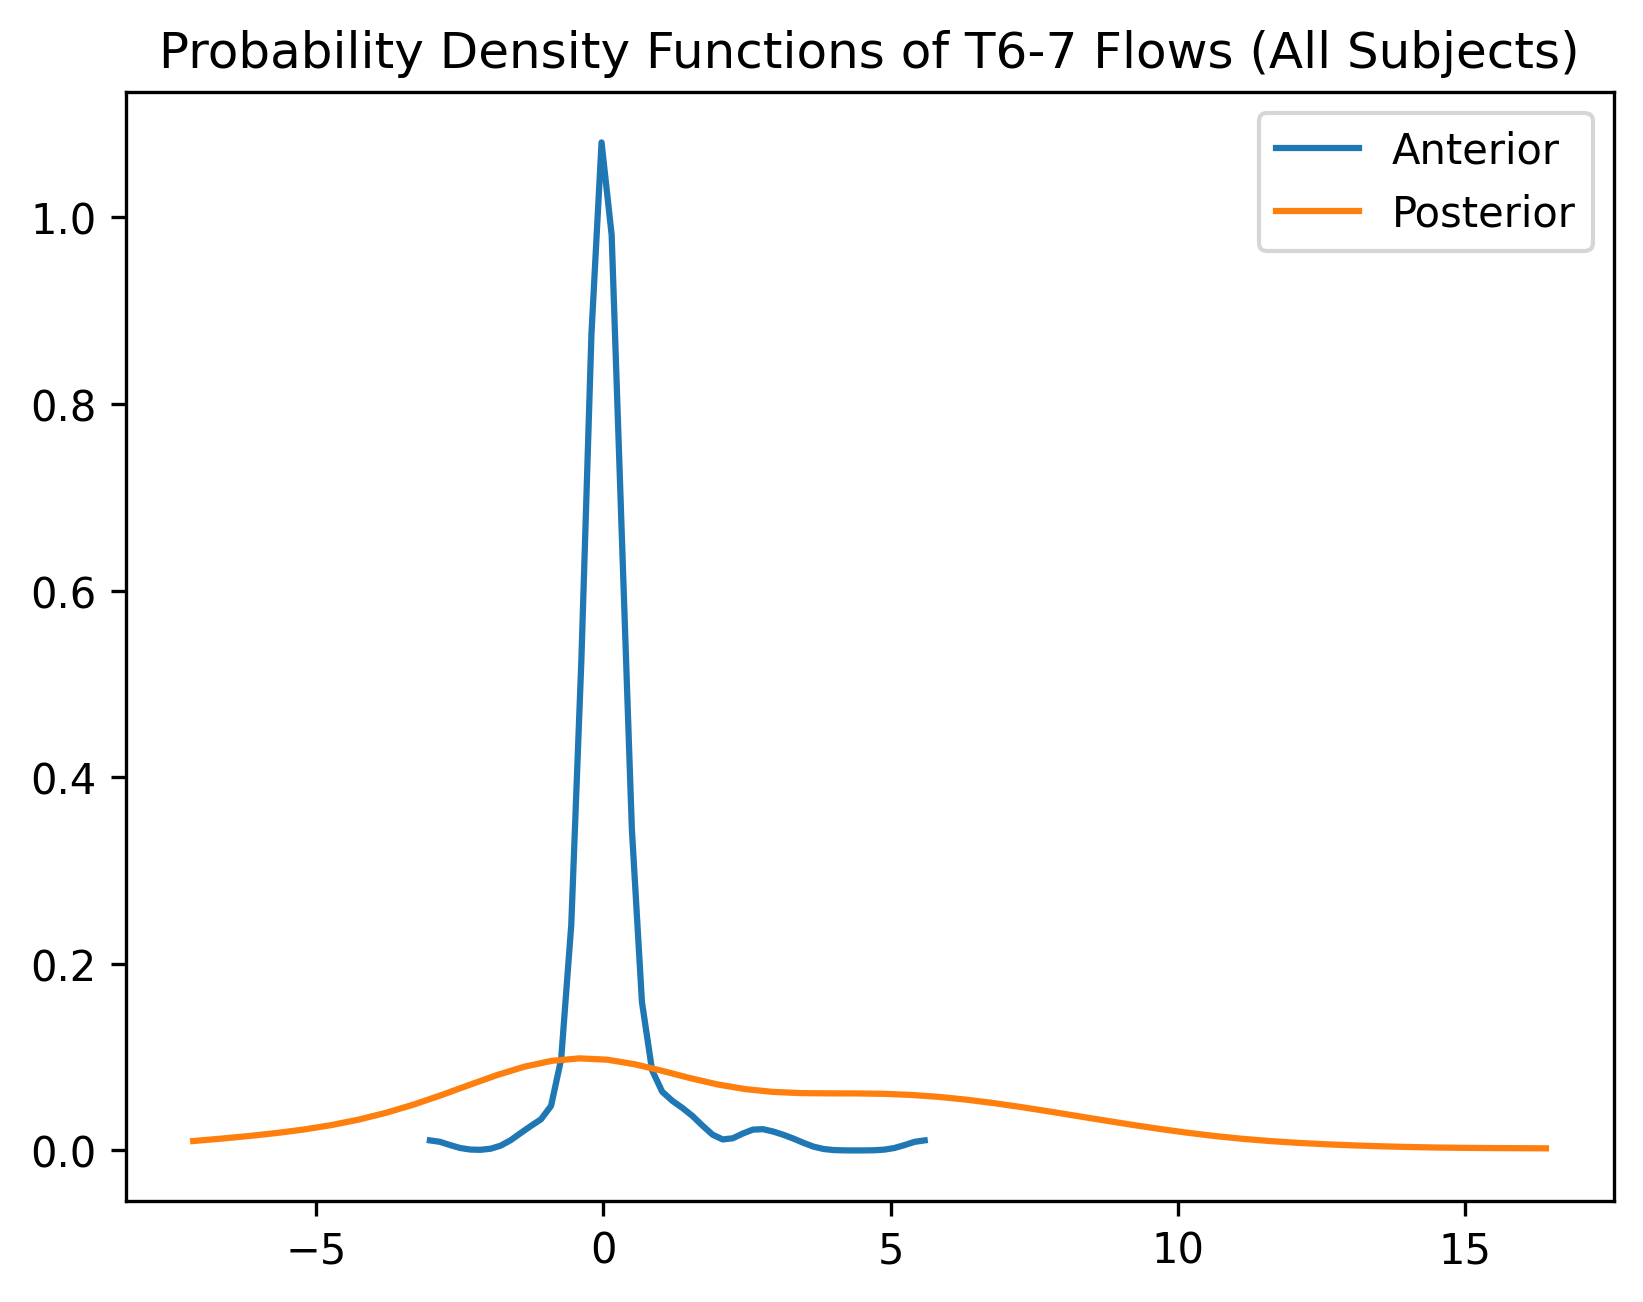

In [37]:
plt.plot(t6_7_anterior_x, t6_7_anterior_pdf, label='Anterior')
plt.plot(t6_7_posterior_x, t6_7_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of T6-7 Flows (All Subjects)')
plt.legend()

# Plot all PDFs for all regions together

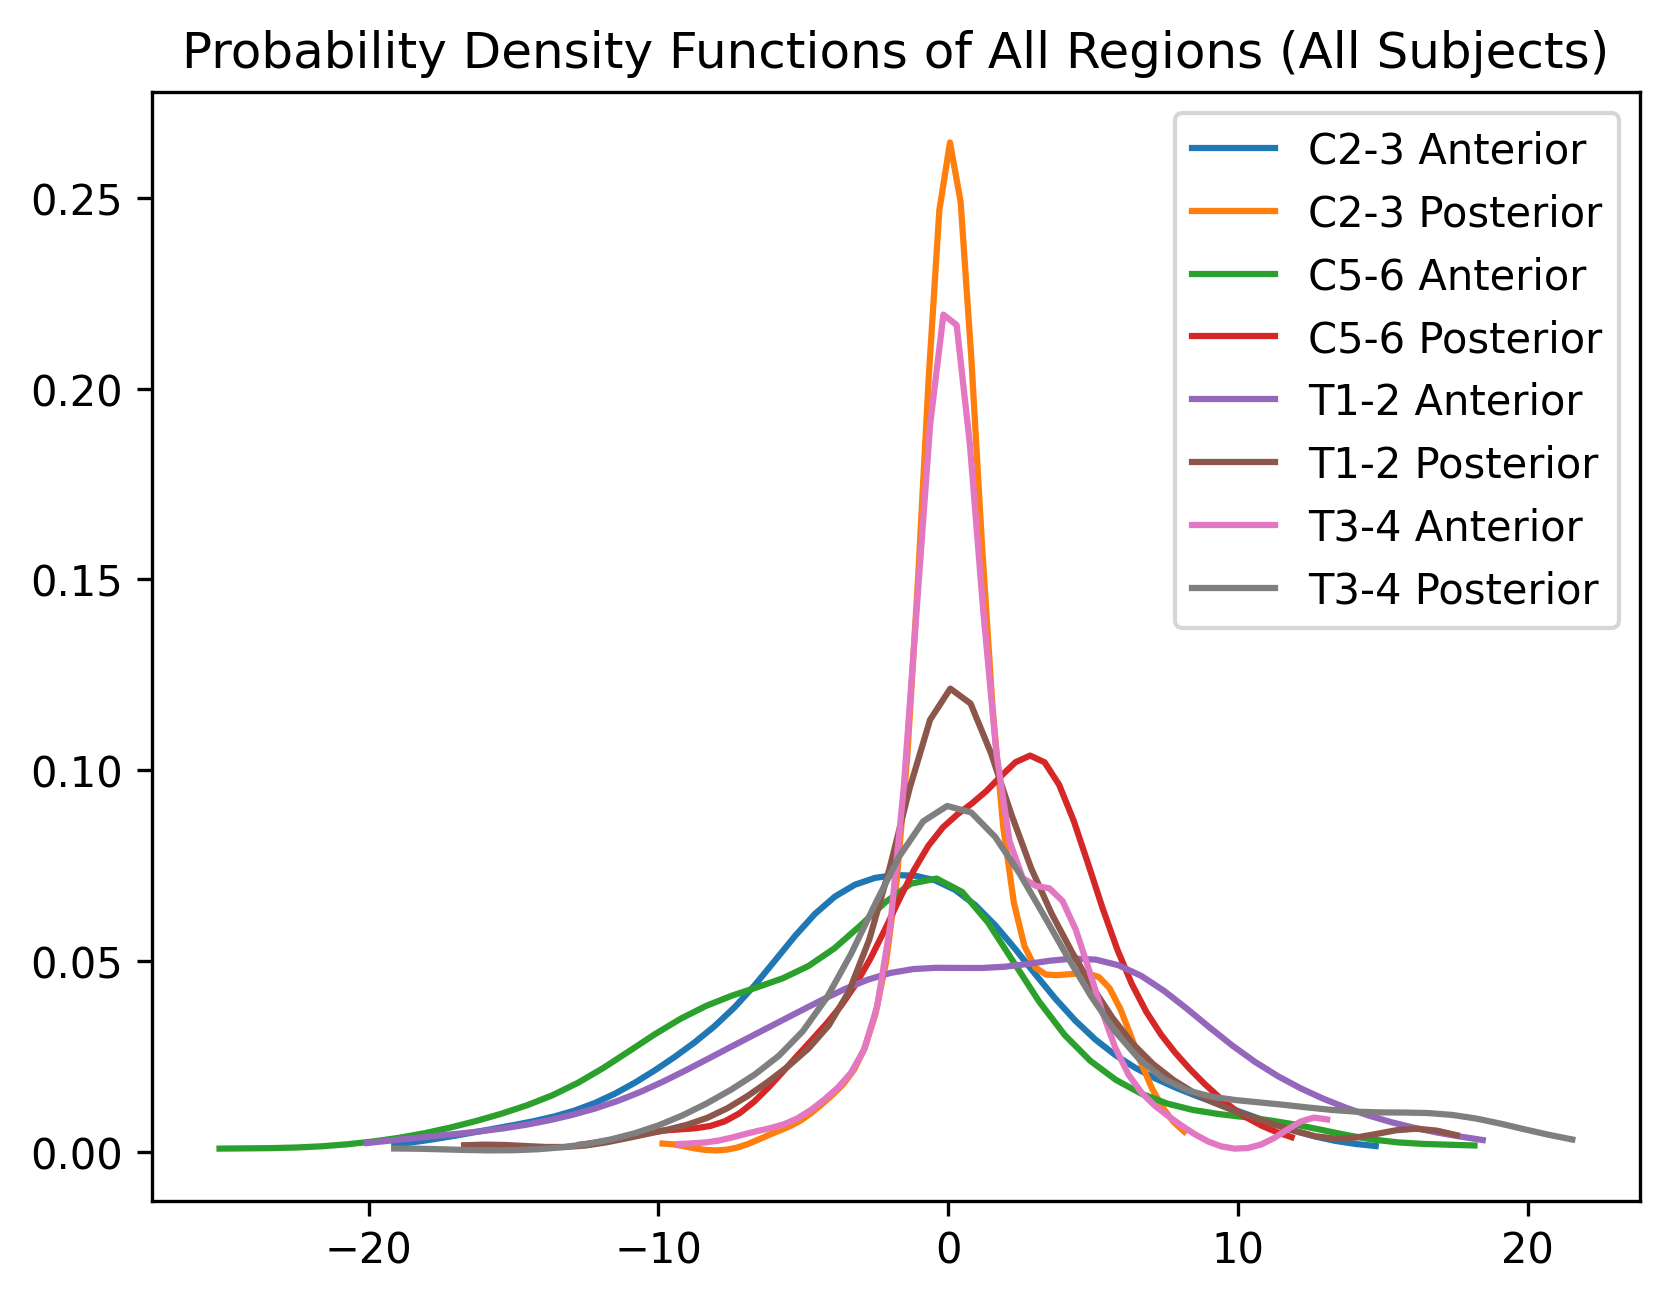

In [38]:
plt.plot(c2_3_anterior_x, c2_3_anterior_pdf, label='C2-3 Anterior')
plt.plot(c2_3_posterior_x, c2_3_posterior_pdf, label='C2-3 Posterior')
plt.plot(c5_6_anterior_x, c5_6_anterior_pdf, label='C5-6 Anterior')
plt.plot(c5_6_posterior_x, c5_6_posterior_pdf, label='C5-6 Posterior')
plt.plot(t1_2_anterior_x, t1_2_anterior_pdf, label='T1-2 Anterior')
plt.plot(t1_2_posterior_x, t1_2_posterior_pdf, label='T1-2 Posterior')
plt.plot(t3_4_anterior_x, t3_4_anterior_pdf, label='T3-4 Anterior')
plt.plot(t3_4_posterior_x, t3_4_posterior_pdf, label='T3-4 Posterior')
#plt.plot(t6_7_anterior_x, t6_7_anterior_pdf, label='T6-7 Anterior')
#plt.plot(t6_7_posterior_x, t6_7_posterior_pdf, label='T6-7 Posterior')
plt.title('Probability Density Functions of All Regions (All Subjects)')
plt.legend()

# Plot PDFs/KDEs for Medium/High-quality data only

In [39]:
c2_3 = get_csf_flow_by_region(csf_flow_high_med, 'C2-3').copy()
c5_6 = get_csf_flow_by_region(csf_flow_high_med, 'C5-6').copy()
t1_2 = get_csf_flow_by_region(csf_flow_high_med, 'T1-2').copy()
t3_4 = get_csf_flow_by_region(csf_flow_high_med, 'T3-4').copy()
t6_7 = get_csf_flow_by_region(csf_flow_high_med, 'T6_7').copy()

In [40]:
# Drop all missing values (NaNs)
c2_3 = c2_3[(c2_3['anterior_midline_shift'].notna()) & (c2_3['posterior_midline_shift'].notna())]
c5_6 = c5_6[(c5_6['anterior_midline_shift'].notna()) & (c5_6['posterior_midline_shift'].notna())]
t1_2 = t1_2[(t1_2['anterior_midline_shift'].notna()) & (t1_2['posterior_midline_shift'].notna())]
t3_4 = t3_4[(t3_4['anterior_midline_shift'].notna()) & (t3_4['posterior_midline_shift'].notna())]
t6_7 = t6_7[(t6_7['anterior_midline_shift'].notna()) & (t6_7['posterior_midline_shift'].notna())]

In [41]:
# Get the anterior and posterior data for all regions
c2_3_anterior_midlines = c2_3['anterior_midline_shift']
c2_3_posterior_midlines = c2_3['posterior_midline_shift']

c5_6_anterior_midlines = c5_6['anterior_midline_shift']
c5_6_posterior_midlines = c5_6['posterior_midline_shift']

t1_2_anterior_midlines = t1_2['anterior_midline_shift']
t1_2_posterior_midlines = t1_2['posterior_midline_shift']

t3_4_anterior_midlines = t3_4['anterior_midline_shift']
t3_4_posterior_midlines = t3_4['posterior_midline_shift']

t6_7_anterior_midlines = t6_7['anterior_midline_shift']
t6_7_posterior_midlines = t6_7['posterior_midline_shift']

### Calculate KDE and PDF for C2-3 (high/medium quality only)

In [42]:
c2_3_anterior_kde = calculate_kernel_density(c2_3_anterior_midlines)
c2_3_anterior_x = np.linspace(c2_3_anterior_midlines.min(), c2_3_anterior_midlines.max())
c2_3_anterior_pdf = c2_3_anterior_kde.evaluate(c2_3_anterior_x)

c2_3_posterior_kde = calculate_kernel_density(c2_3_posterior_midlines)
c2_3_posterior_x = np.linspace(c2_3_posterior_midlines.min(), c2_3_posterior_midlines.max())
c2_3_posterior_pdf = c2_3_posterior_kde.evaluate(c2_3_posterior_x)

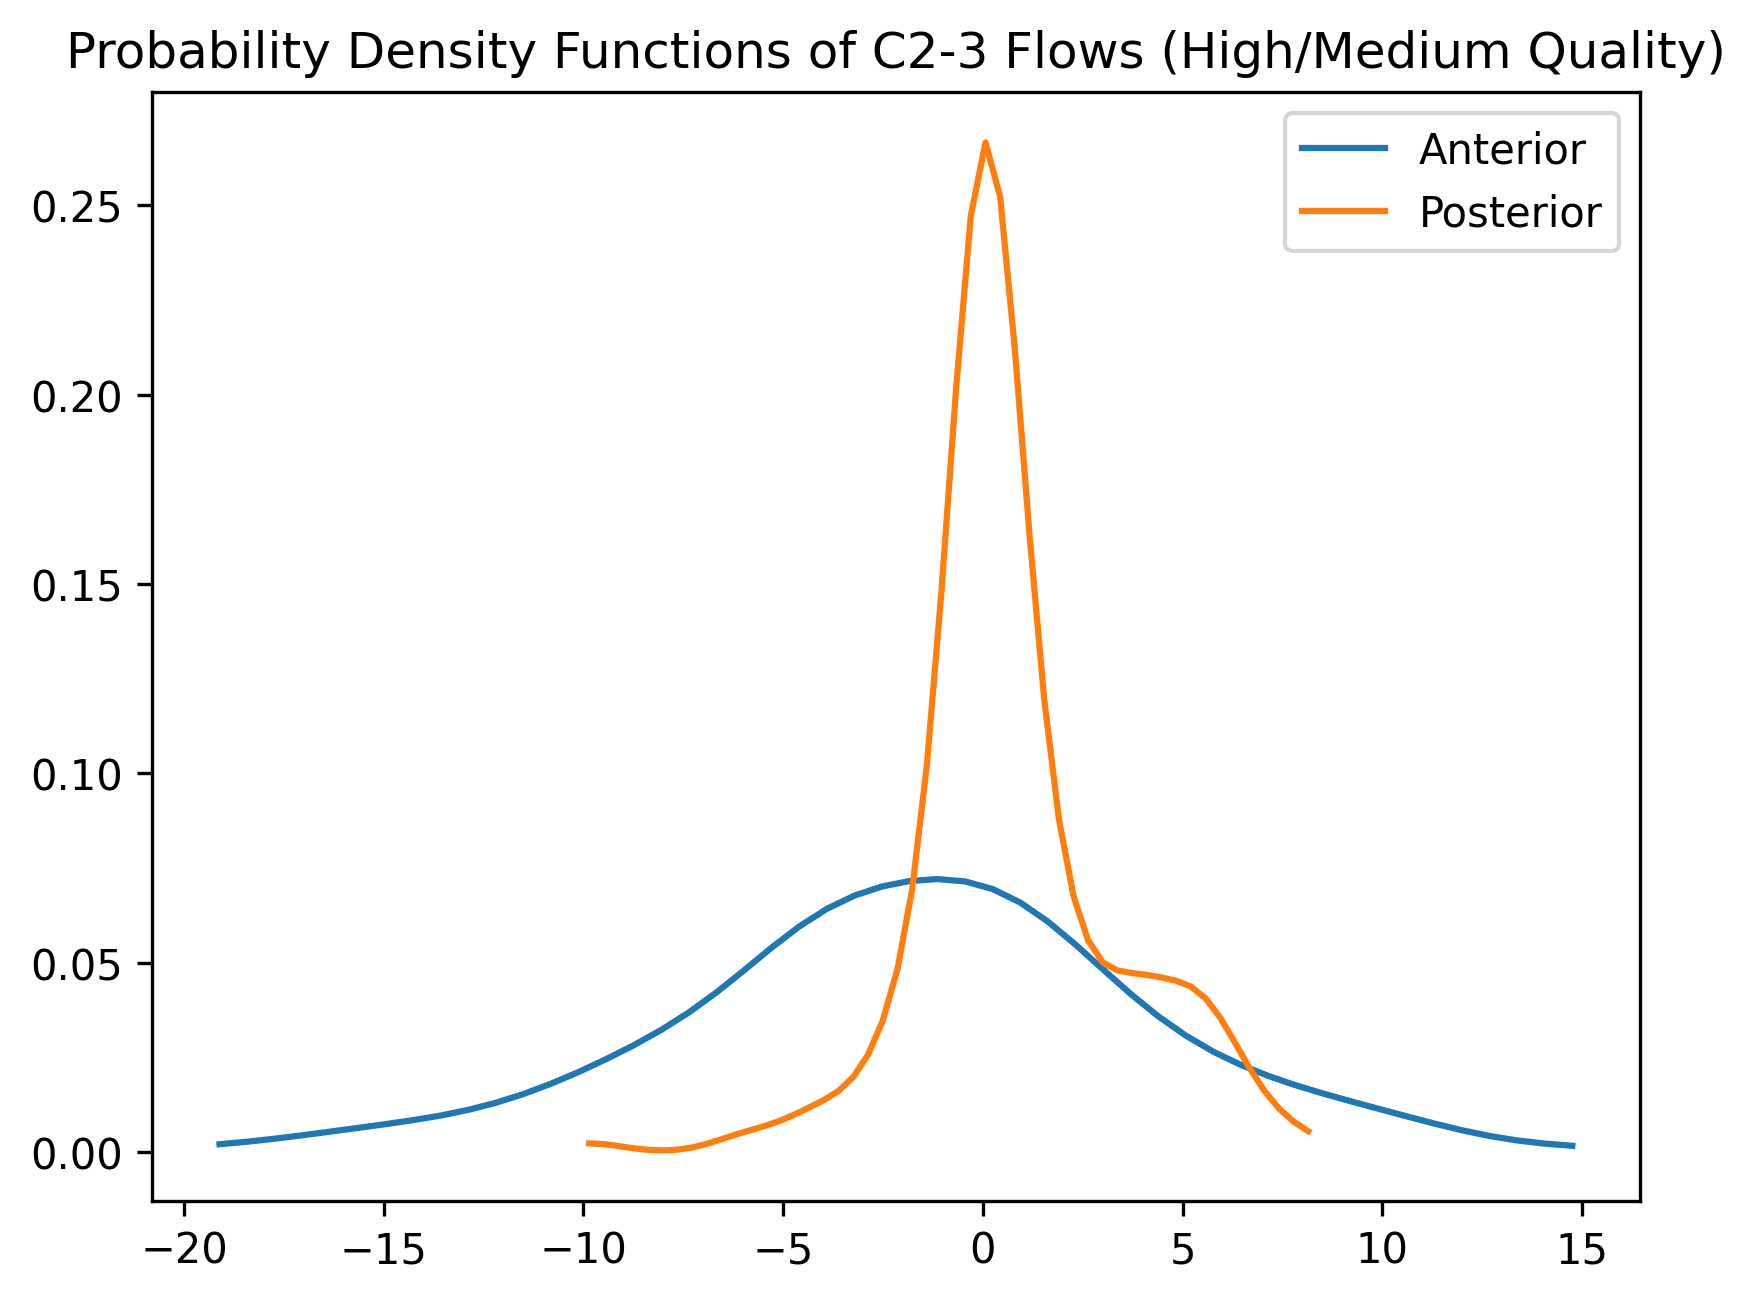

In [43]:
plt.plot(c2_3_anterior_x, c2_3_anterior_pdf, label='Anterior')
plt.plot(c2_3_posterior_x, c2_3_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of C2-3 Flows (High/Medium Quality)')
plt.legend()

### Calculate KDE and PDF for C5-6 (high/medium quality only)

In [44]:
c5_6_anterior_kde = calculate_kernel_density(c5_6_anterior_midlines)
c5_6_anterior_x = np.linspace(c5_6_anterior_midlines.min(), c5_6_anterior_midlines.max())
c5_6_anterior_pdf = c5_6_anterior_kde.evaluate(c5_6_anterior_x)

c5_6_posterior_kde = calculate_kernel_density(c5_6_posterior_midlines)
c5_6_posterior_x = np.linspace(c5_6_posterior_midlines.min(), c5_6_posterior_midlines.max())
c5_6_posterior_pdf = c5_6_posterior_kde.evaluate(c5_6_posterior_x)

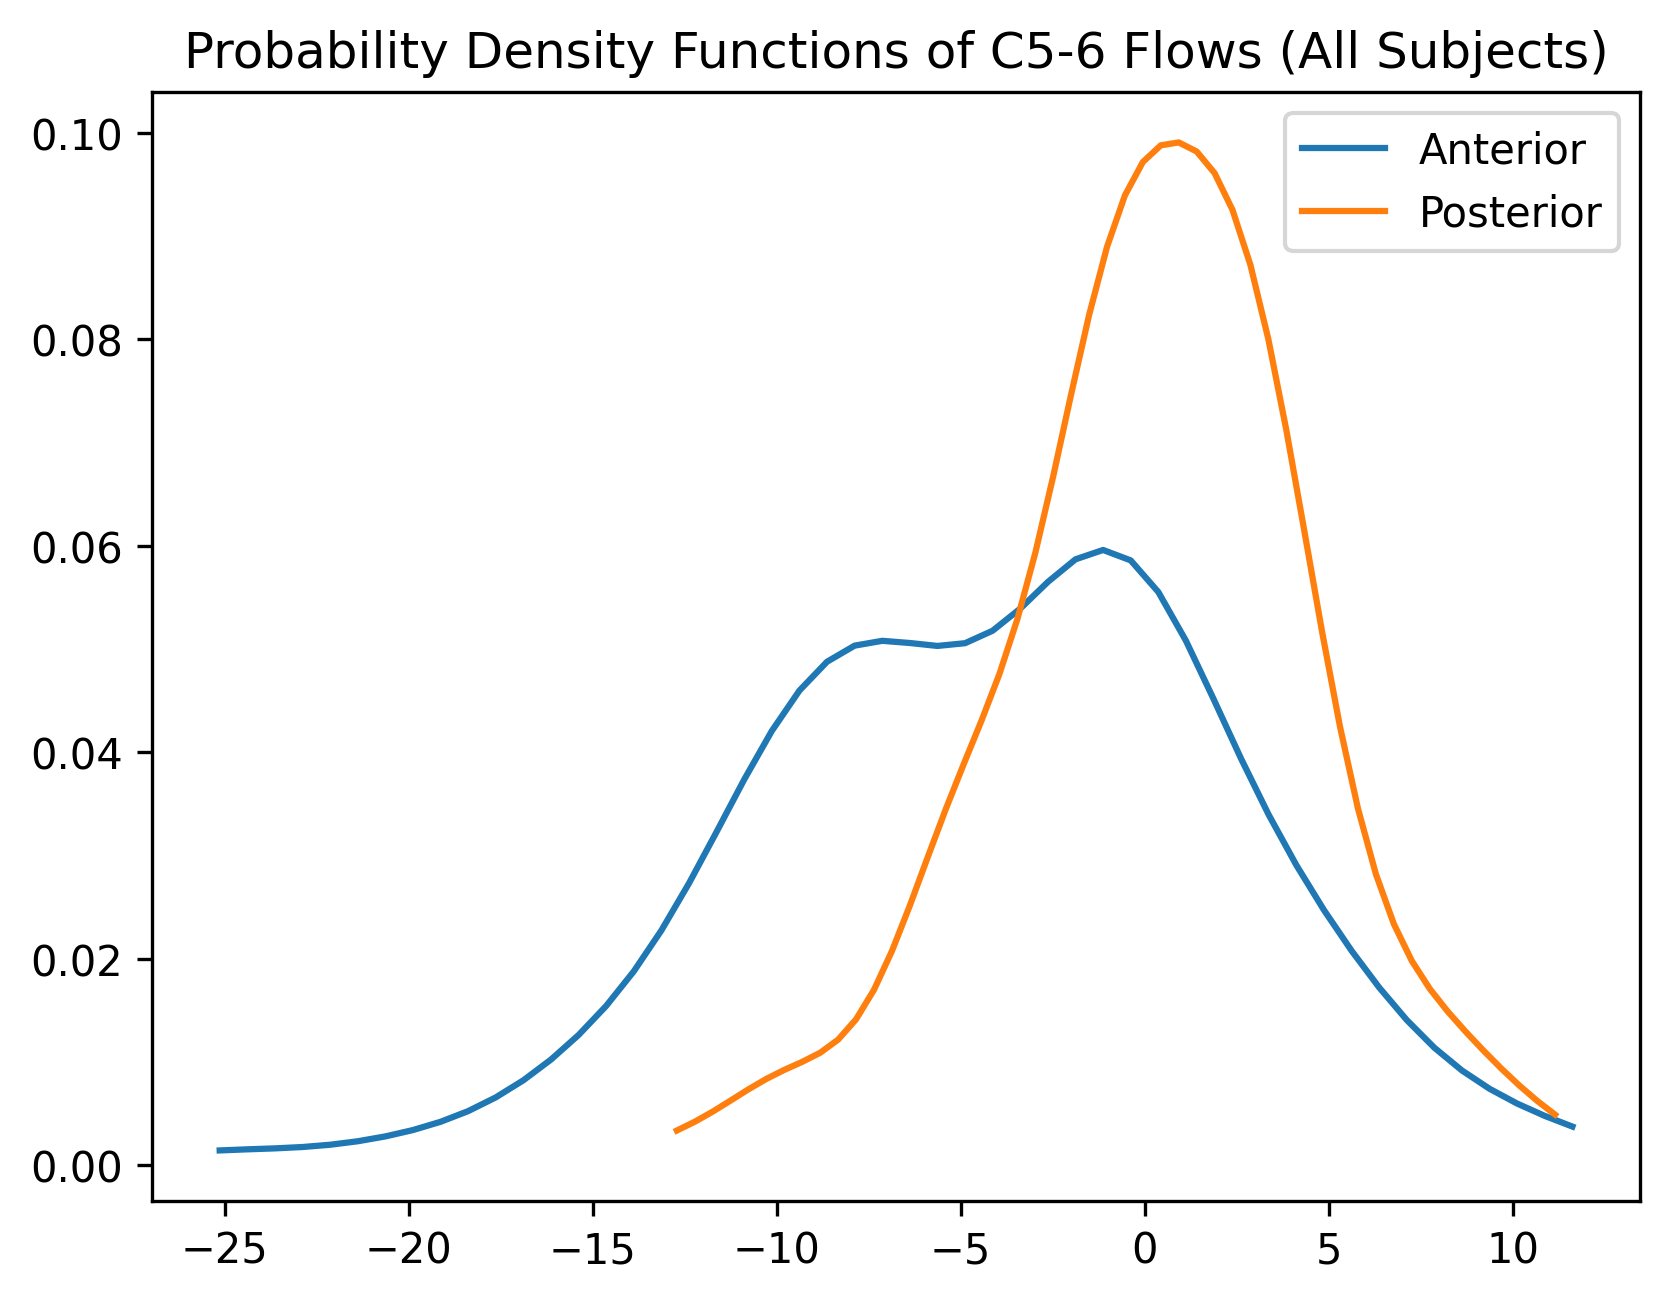

In [45]:
plt.plot(c5_6_anterior_x, c5_6_anterior_pdf, label='Anterior')
plt.plot(c5_6_posterior_x, c5_6_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of C5-6 Flows (All Subjects)')
plt.legend()

### Calculate KDE and PDF for T1-2 (high/medium quality only)

In [46]:
t1_2_anterior_kde = calculate_kernel_density(t1_2_anterior_midlines)
t1_2_anterior_x = np.linspace(t1_2_anterior_midlines.min(), t1_2_anterior_midlines.max())
t1_2_anterior_pdf = t1_2_anterior_kde.evaluate(t1_2_anterior_x)

t1_2_posterior_kde = calculate_kernel_density(t1_2_posterior_midlines)
t1_2_posterior_x = np.linspace(t1_2_posterior_midlines.min(), t1_2_posterior_midlines.max())
t1_2_posterior_pdf = t1_2_posterior_kde.evaluate(t1_2_posterior_x)

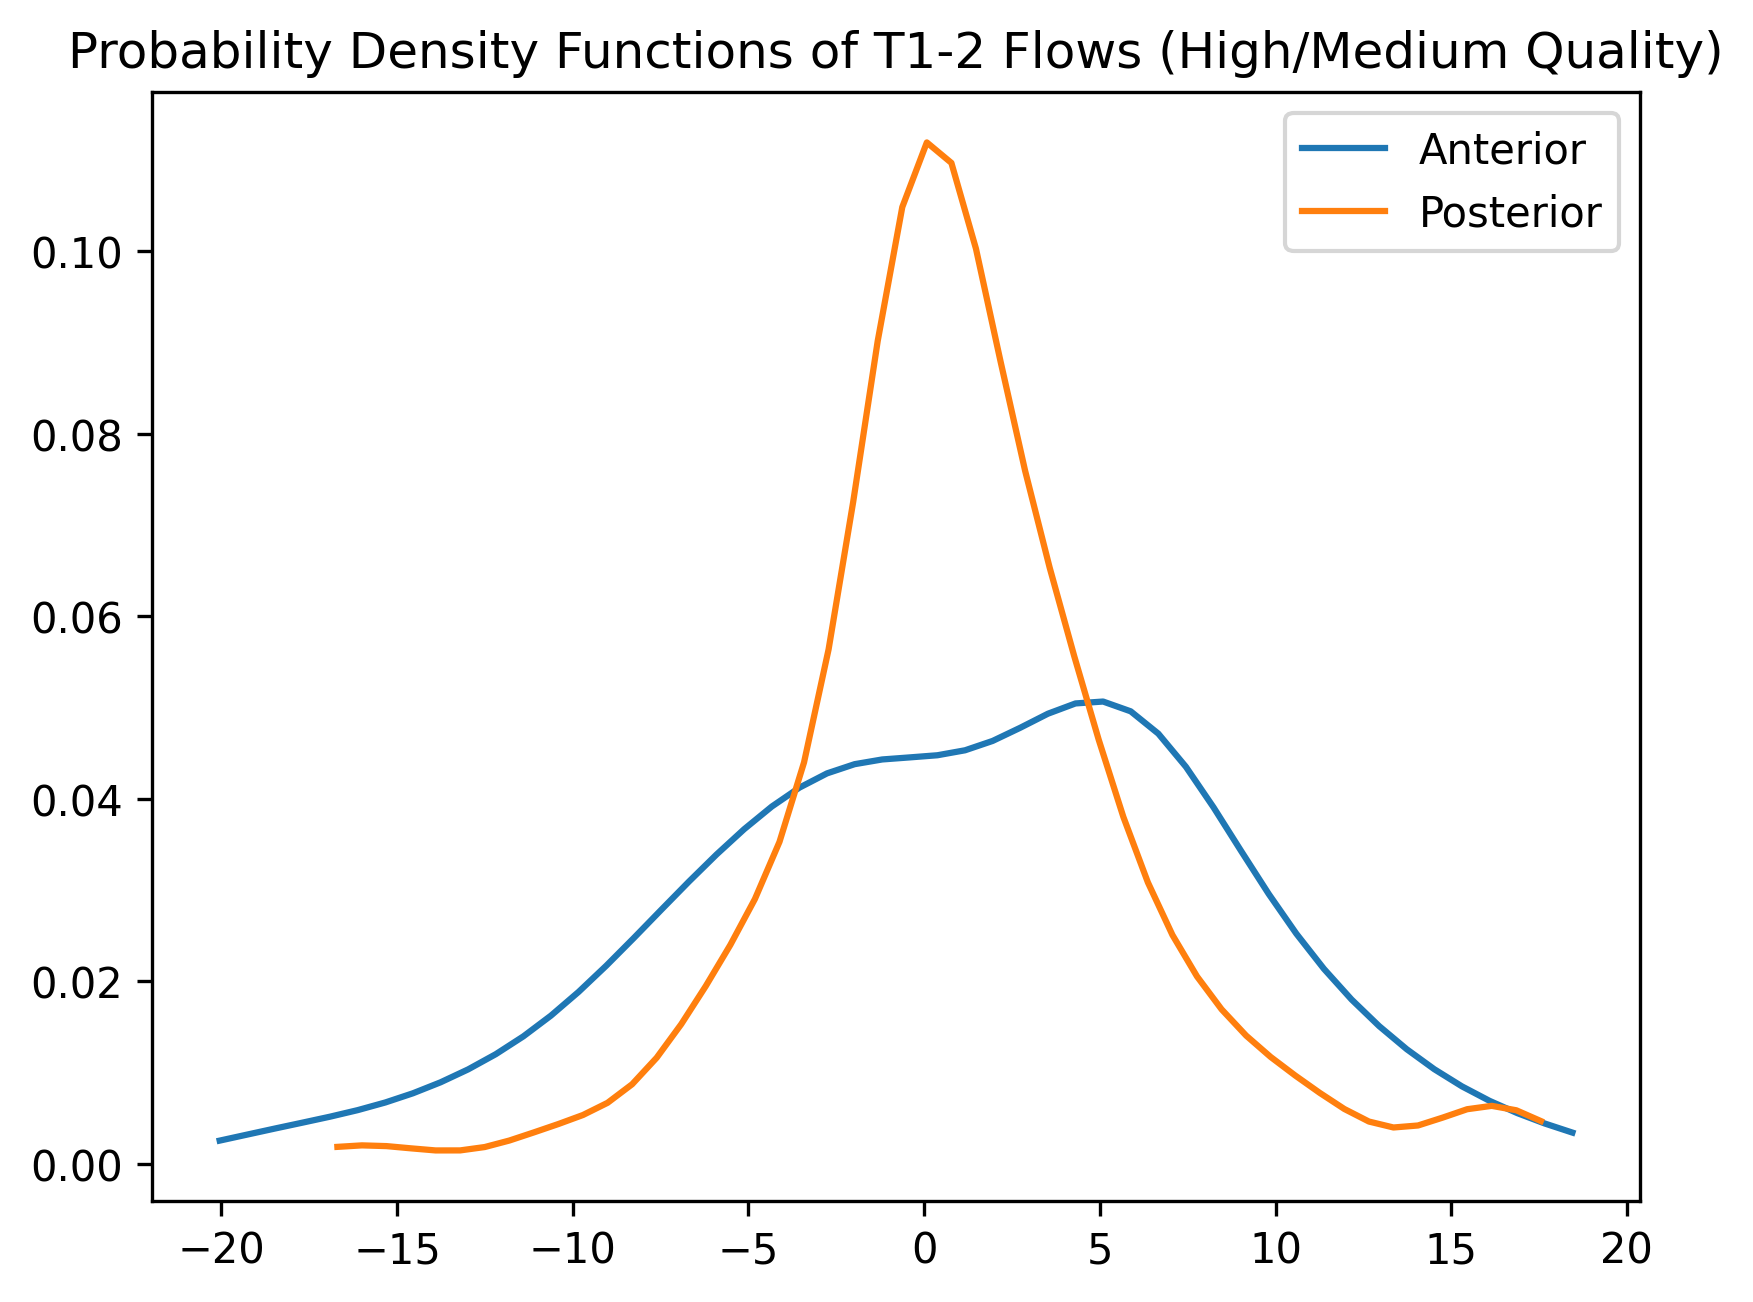

In [47]:
plt.plot(t1_2_anterior_x, t1_2_anterior_pdf, label='Anterior')
plt.plot(t1_2_posterior_x, t1_2_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of T1-2 Flows (High/Medium Quality)')
plt.legend()

### Calculate KDE and PDF for T3-4 (high/medium quality only)

In [48]:
t3_4_anterior_kde = calculate_kernel_density(t3_4_anterior_midlines)
t3_4_anterior_x = np.linspace(t3_4_anterior_midlines.min(), t3_4_anterior_midlines.max())
t3_4_anterior_pdf = t3_4_anterior_kde.evaluate(t3_4_anterior_x)

t3_4_posterior_kde = calculate_kernel_density(t3_4_posterior_midlines)
t3_4_posterior_x = np.linspace(t3_4_posterior_midlines.min(), t3_4_posterior_midlines.max())
t3_4_posterior_pdf = t3_4_posterior_kde.evaluate(t3_4_posterior_x)

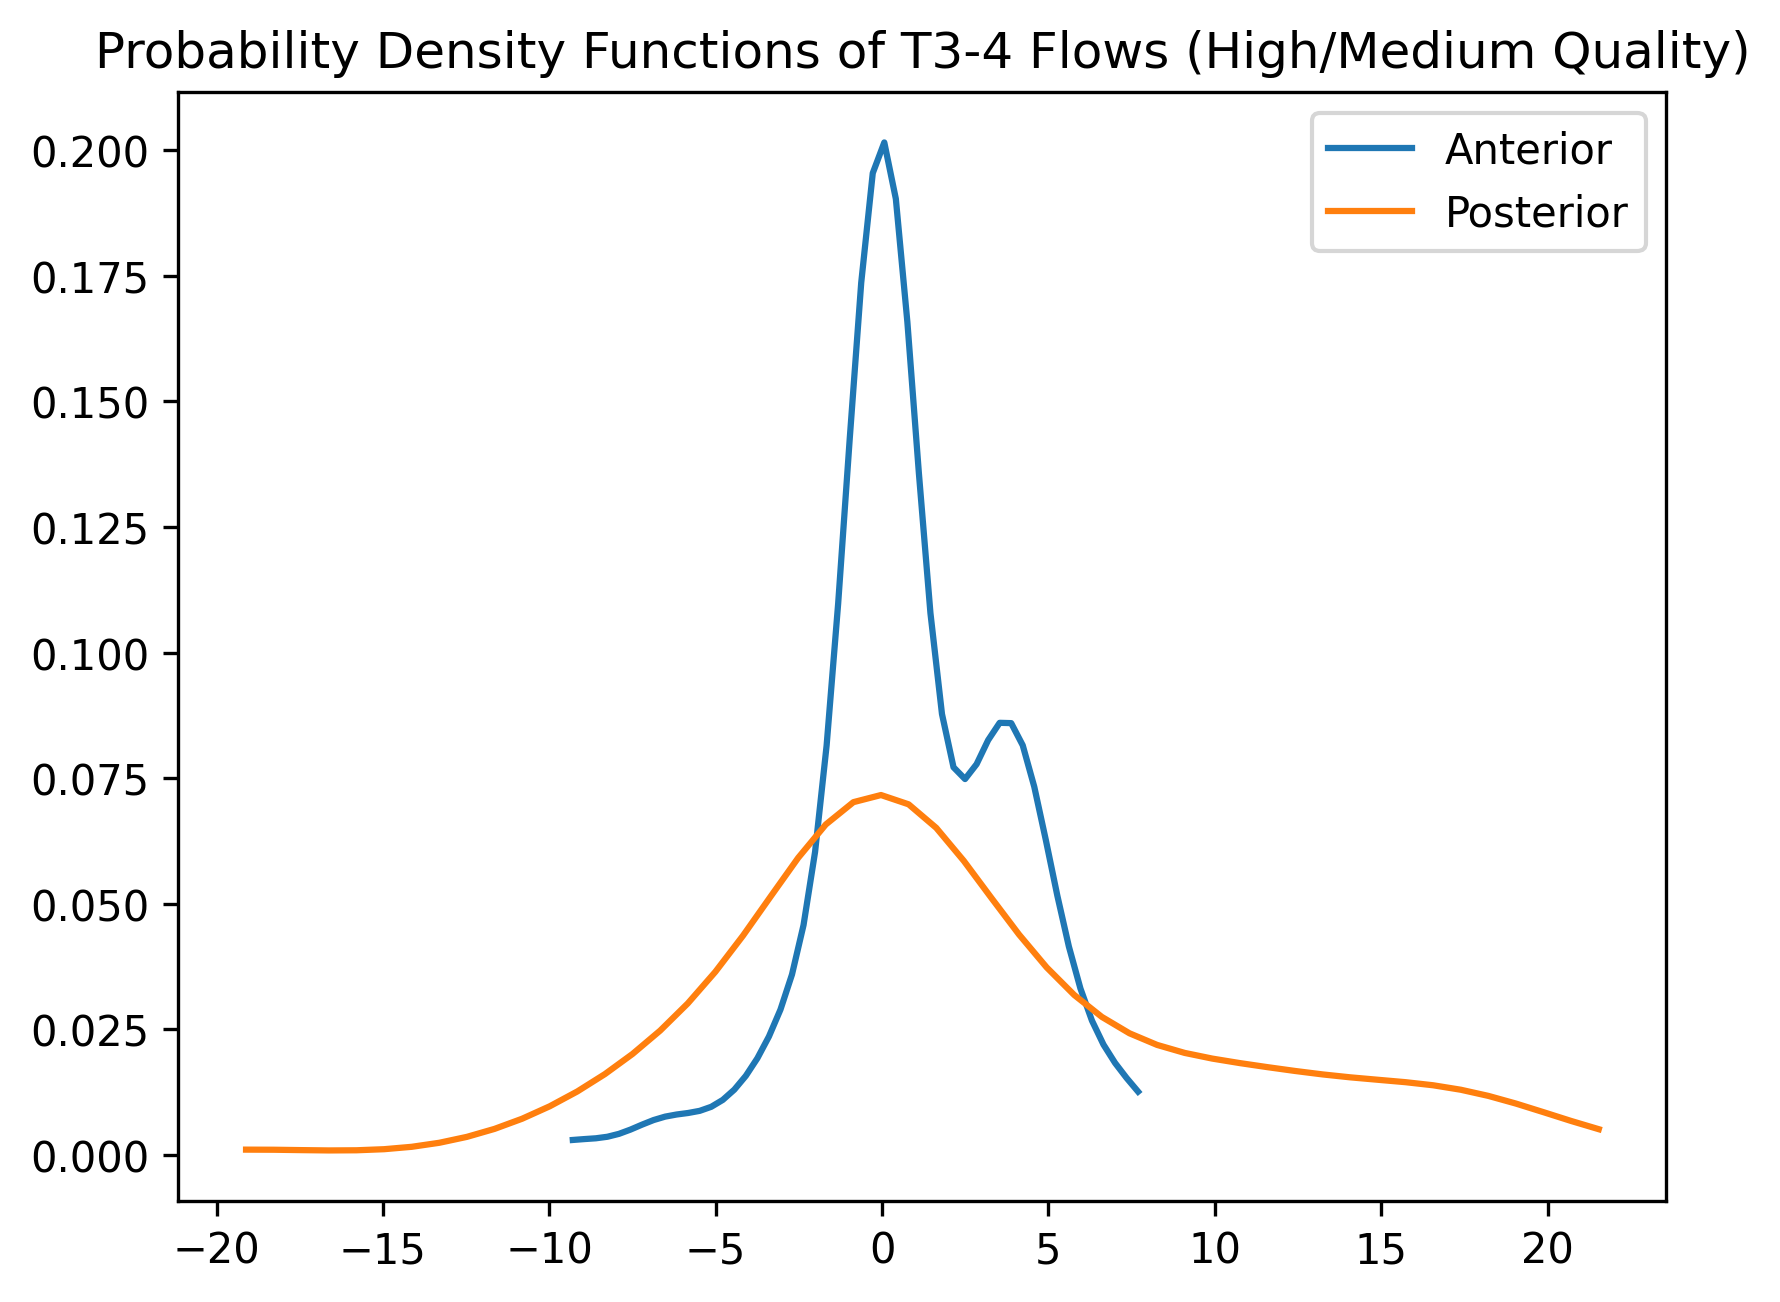

In [49]:
plt.plot(t3_4_anterior_x, t3_4_anterior_pdf, label='Anterior')
plt.plot(t3_4_posterior_x, t3_4_posterior_pdf, label='Posterior')
plt.title('Probability Density Functions of T3-4 Flows (High/Medium Quality)')
plt.legend()

### Calculate KDE and PDF for T6-7 (high/medium quality only)

In [50]:
t6_7_anterior_midlines

Series([], Name: anterior_midline_shift, dtype: float64)

In [51]:
# This section is commented out, because there is not enough T6-7 anterior data to calculate with
#t6_7_anterior_kde = calculate_kernel_density(t6_7_anterior_midlines)
#t6_7_anterior_x = np.linspace(t6_7_anterior_midlines.min(), t6_7_anterior_midlines.max())
#t6_7_anterior_pdf = t6_7_anterior_kde.evaluate(t6_7_anterior_x)

#t6_7_posterior_kde = calculate_kernel_density(t6_7_posterior_midlines)
#t6_7_posterior_x = np.linspace(t6_7_posterior_midlines.min(), t6_7_posterior_midlines.max())
#t6_7_posterior_pdf = t6_7_posterior_kde.evaluate(t6_7_posterior_x)

# Plot all PDFs for High/Medium Quality Flows Together

**NOTE:** There is not enough high/medium quality data in the T6-7 region, so those measurements were excluded from the graph.

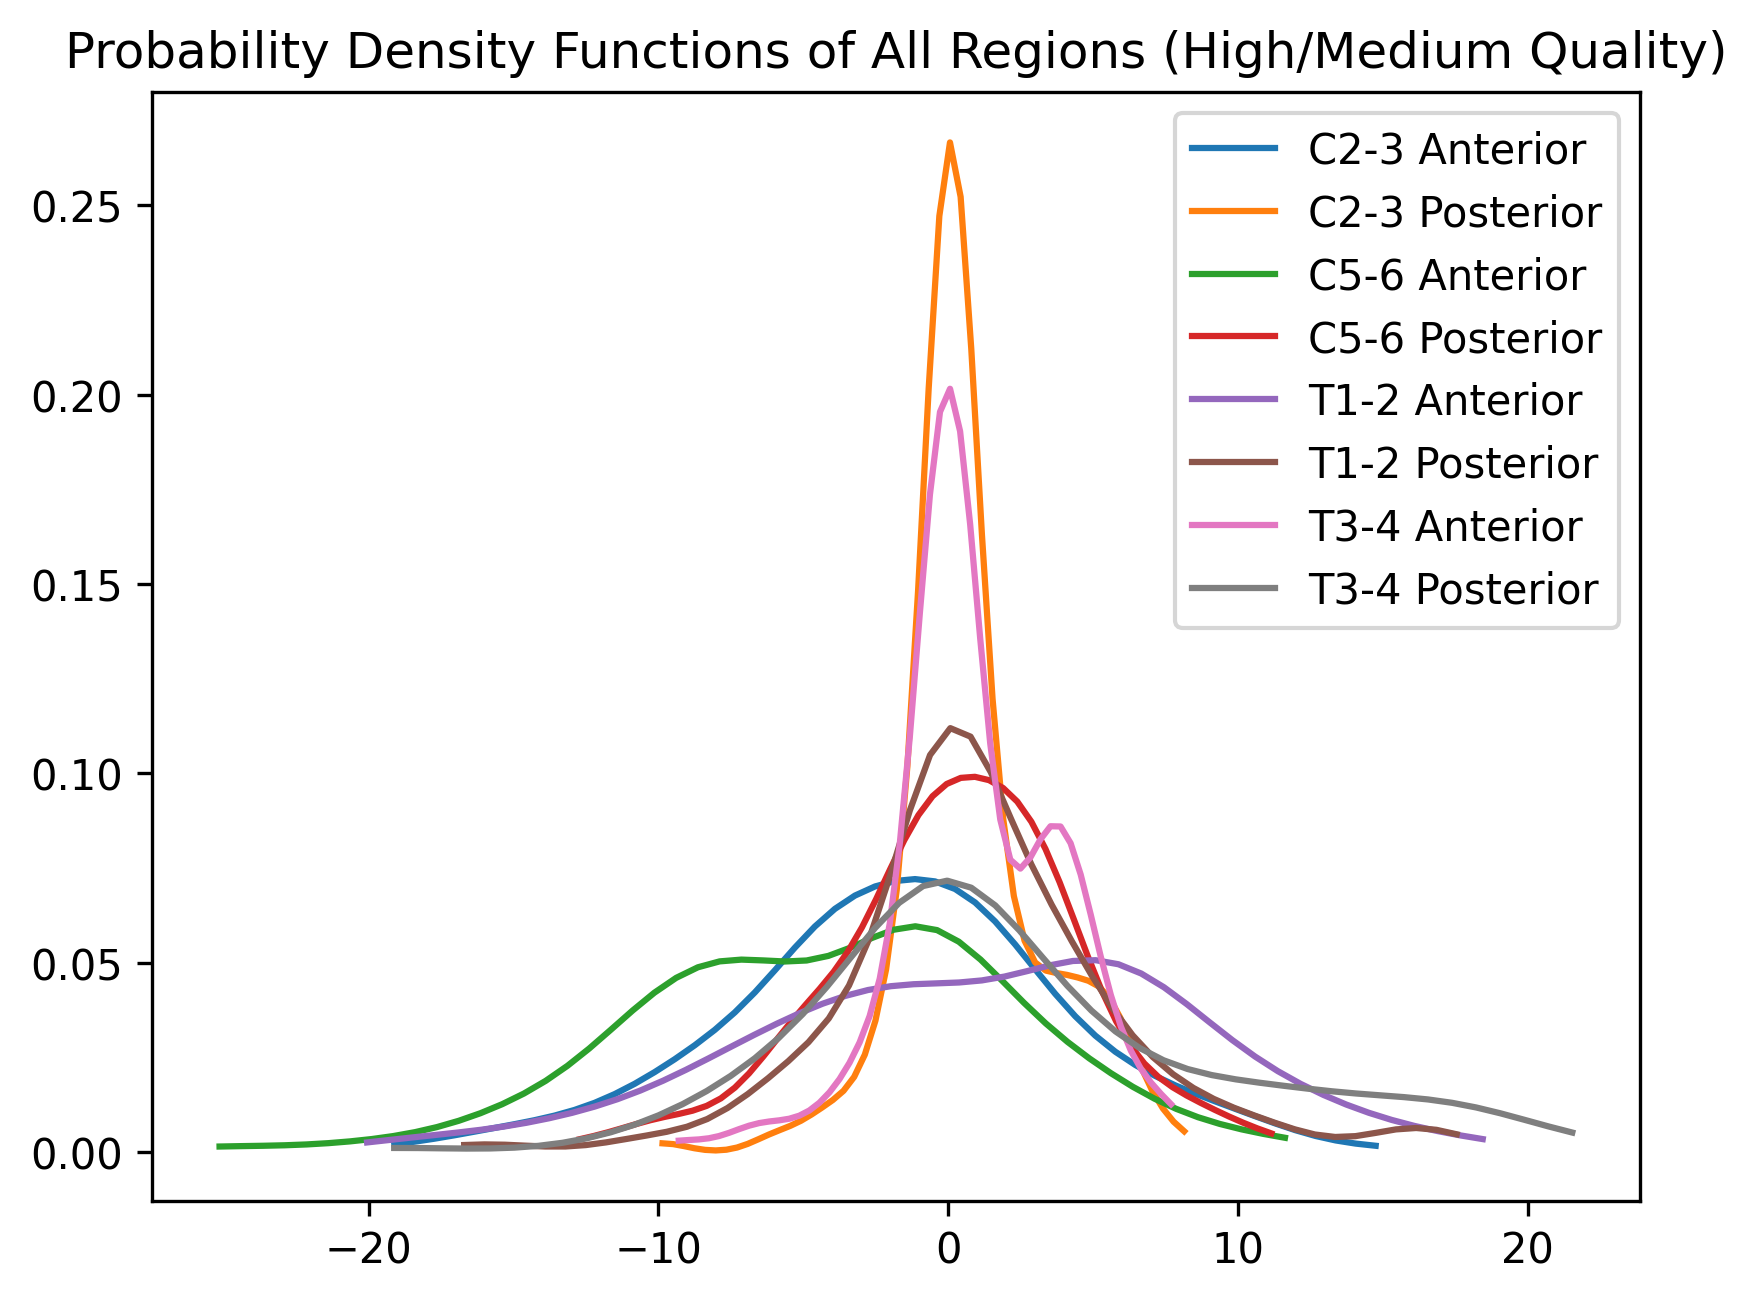

In [52]:
plt.plot(c2_3_anterior_x, c2_3_anterior_pdf, label='C2-3 Anterior')
plt.plot(c2_3_posterior_x, c2_3_posterior_pdf, label='C2-3 Posterior')
plt.plot(c5_6_anterior_x, c5_6_anterior_pdf, label='C5-6 Anterior')
plt.plot(c5_6_posterior_x, c5_6_posterior_pdf, label='C5-6 Posterior')
plt.plot(t1_2_anterior_x, t1_2_anterior_pdf, label='T1-2 Anterior')
plt.plot(t1_2_posterior_x, t1_2_posterior_pdf, label='T1-2 Posterior')
plt.plot(t3_4_anterior_x, t3_4_anterior_pdf, label='T3-4 Anterior')
plt.plot(t3_4_posterior_x, t3_4_posterior_pdf, label='T3-4 Posterior')
plt.title('Probability Density Functions of All Regions (High/Medium Quality)')
plt.legend()